# DỰ ĐOÁN GIÁ VÀ PHÂN CỤM KIM CƯƠNG

## IMPORT CÁC THƯ VIỆN CẦN THIẾT 

In [101]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import silhouette_score,davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
plt.rcParams.update({
    'font.size': 16,        # kích cỡ font mặc định cho toàn bộ text trong biểu đồ
    'axes.titlesize': 18,   # font size cho tiêu đề axes
    'axes.labelsize': 16,   # font size cho nhãn trục x,y
    'xtick.labelsize': 14,  # font size cho tick trục x
    'ytick.labelsize': 14,  # font size cho tick trục y
    'legend.fontsize': 14   # font size cho chú giải legend
})

## DỮ LIỆU SAU KHI CRAWL

In [102]:
df = pd.read_csv('diamond_full_data.csv')
df.head()

,carat,color,clarity,cut,table,depth,measurements,price
0,0.54,G,SI2,Excellent,58 %,62.2 %,5.2x5.22x3.24,$989
1,0.52,F,SI1,Excellent,57 %,62.1 %,5.13x5.15x3.19,"$1,111"
2,0.50,E,SI1,Excellent,60 %,60.8 %,5.09x5.13x3.11,"$1,197"
3,0.50,E,SI1,Excellent,61 %,60.7 %,5.13x5.15x3.12,"$1,225"
4,0.50,H,VS2,Excellent,57 %,63.3 %,5.03x5.06x3.19,"$1,155"


In [103]:
print(df.info())
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11385 entries, 0 to 11384
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carat         11385 non-null  float64
 1   color         11385 non-null  object 
 2   clarity       11385 non-null  object 
 3   cut           11385 non-null  object 
 4   table         11385 non-null  object 
 5   depth         11385 non-null  object 
 6   measurements  11385 non-null  object 
 7   price         9107 non-null   object 
dtypes: float64(1), object(7)
memory usage: 711.7+ KB
None
carat              0
color              0
clarity            0
cut                0
table              0
depth              0
measurements       0
price           2278
dtype: int64


## DATA CLEANING

### DROP CÁC RECORDS BỊ MISSING DATA Ở PRICE 

In [104]:
df.dropna(inplace=True)


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9107 entries, 0 to 11384
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carat         9107 non-null   float64
 1   color         9107 non-null   object 
 2   clarity       9107 non-null   object 
 3   cut           9107 non-null   object 
 4   table         9107 non-null   object 
 5   depth         9107 non-null   object 
 6   measurements  9107 non-null   object 
 7   price         9107 non-null   object 
dtypes: float64(1), object(7)
memory usage: 640.3+ KB


In [106]:
df.head()

,carat,color,clarity,cut,table,depth,measurements,price
0,0.54,G,SI2,Excellent,58 %,62.2 %,5.2x5.22x3.24,$989
1,0.52,F,SI1,Excellent,57 %,62.1 %,5.13x5.15x3.19,"$1,111"
2,0.50,E,SI1,Excellent,60 %,60.8 %,5.09x5.13x3.11,"$1,197"
3,0.50,E,SI1,Excellent,61 %,60.7 %,5.13x5.15x3.12,"$1,225"
4,0.50,H,VS2,Excellent,57 %,63.3 %,5.03x5.06x3.19,"$1,155"


### XÓA ĐI CÁC KÍ TỰ $,% ,... TÁCH MEASUREMENTS THÀNH X,Y,Z VÀ ÉP KIỂU STRING -> FLOAT

In [107]:
df["price"] = df["price"].replace('[\$,]', '', regex=True).astype(float)


df['table'] = df['table'].str.replace(' %', '').astype(float)
df['depth'] = df['depth'].str.replace(' %', '').astype(float)

df['measurements'] = df['measurements'].str.replace('X', 'x')
df[["x", "y", "z"]] = df["measurements"].str.split("x", expand=True)

# (Tuỳ chọn) Xoá cột measurements gốc
df.drop(columns=["measurements"], inplace=True)

# (Tuỳ chọn) Đổi kiểu x, y, z về float
df[["x", "y", "z","depth","table","carat"]] = df[["x", "y", "z","depth","table","carat"]].astype(float)


<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\quock\AppData\Local\Temp\ipykernel_40392\488478571.py:1: SyntaxWarning: invalid escape sequence '\$'
  df["price"] = df["price"].replace('[\$,]', '', regex=True).astype(float)


In [108]:
df.head()

,carat,color,clarity,cut,table,depth,price,x,y,z
0,0.54,G,SI2,Excellent,58.0,62.2,989.0,5.20,5.22,3.24
1,0.52,F,SI1,Excellent,57.0,62.1,1111.0,5.13,5.15,3.19
2,0.50,E,SI1,Excellent,60.0,60.8,1197.0,5.09,5.13,3.11
3,0.50,E,SI1,Excellent,61.0,60.7,1225.0,5.13,5.15,3.12
4,0.50,H,VS2,Excellent,57.0,63.3,1155.0,5.03,5.06,3.19


In [109]:
df.describe()

,carat,table,depth,price,x,y,z
count,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000,9107.000000
mean,0.924654,57.624245,62.103635,6022.932799,6.044038,6.078621,3.766365
std,0.574320,1.504228,1.087881,18865.958721,0.937442,0.944968,0.599476
min,0.500000,53.000000,57.400000,461.000000,4.890000,4.950000,3.020000
25%,0.590000,57.000000,61.500000,1431.000000,5.370000,5.400000,3.310000
50%,0.800000,58.000000,62.400000,2663.000000,5.890000,5.930000,3.680000
75%,1.010000,59.000000,62.700000,4985.500000,6.380000,6.410000,4.000000
max,10.290000,64.000000,65.300000,981619.000000,13.850000,13.930000,8.680000


## CHIA DỮ LIỆU SAU KHI CLEAN THÀNH 2 TẬP TRAIN & TEST

### TRỰC QUAN BIẾN MỤC TIÊU PRICE TRƯỚC KHI CHIA 

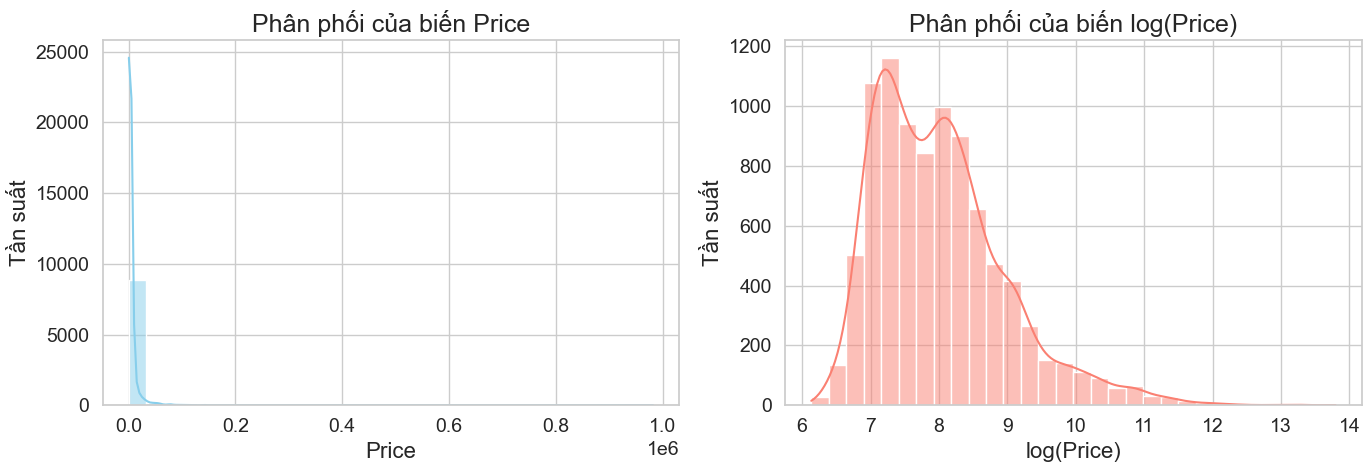

In [110]:

# Tạo thêm cột log_price
df['log_price'] = np.log(df['price'])

# Vẽ 2 biểu đồ cạnh nhau
plt.figure(figsize=(14, 5))

# Biểu đồ gốc - Price
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='price', kde=True, bins=30, color='skyblue')
plt.title('Phân phối của biến Price')
plt.xlabel('Price')
plt.ylabel('Tần suất')

# Biểu đồ log-transform
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='log_price', kde=True, bins=30, color='salmon')
plt.title('Phân phối của biến log(Price)')
plt.xlabel('log(Price)')
plt.ylabel('Tần suất')

plt.tight_layout()
plt.show()


### TRỰC QUAN TRUNG BÌNH LOG(PRICE) CHO TỪNG BIẾN DANH MỤC

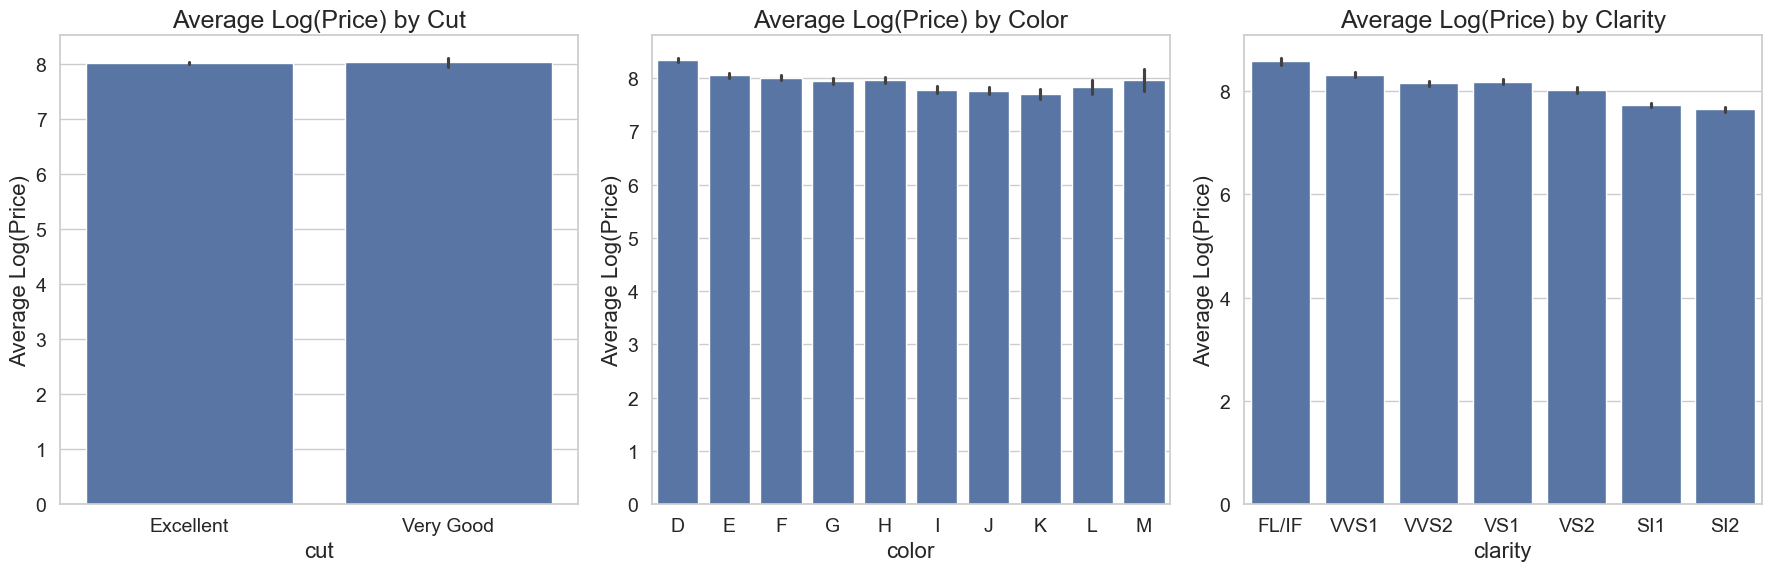

In [111]:
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
clarity_order = ['FL/IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2']
plt.figure(figsize=(18, 6))

# Barplot của trung bình log(price) theo 'cut'
plt.subplot(1, 3, 1)
sns.barplot(data=df, x='cut', y='log_price', estimator=np.mean)
plt.title('Average Log(Price) by Cut')
plt.ylabel('Average Log(Price)')

# Barplot của trung bình log(price) theo 'color'
plt.subplot(1, 3, 2)
sns.barplot(data=df, x='color', y='log_price', estimator=np.mean, order=color_order)
plt.title('Average Log(Price) by Color')
plt.ylabel('Average Log(Price)')

# Barplot của trung bình log(price) theo 'clarity'
plt.subplot(1, 3, 3)
sns.barplot(data=df, x='clarity', y='log_price', estimator=np.mean,  order=clarity_order)
plt.title('Average Log(Price) by Clarity')
plt.ylabel('Average Log(Price)')

plt.tight_layout()
plt.show()

### CHỌN COLOR LÀM BIẾN PHÂN TẦNG CHÍNH

In [112]:
df.head()

,carat,color,clarity,cut,table,depth,price,x,y,z,log_price
0,0.54,G,SI2,Excellent,58.0,62.2,989.0,5.20,5.22,3.24,6.896694
1,0.52,F,SI1,Excellent,57.0,62.1,1111.0,5.13,5.15,3.19,7.013016
2,0.50,E,SI1,Excellent,60.0,60.8,1197.0,5.09,5.13,3.11,7.087574
3,0.50,E,SI1,Excellent,61.0,60.7,1225.0,5.13,5.15,3.12,7.110696
4,0.50,H,VS2,Excellent,57.0,63.3,1155.0,5.03,5.06,3.19,7.051856


So sánh phân bố của biến liên tục giữa Train và Test set:


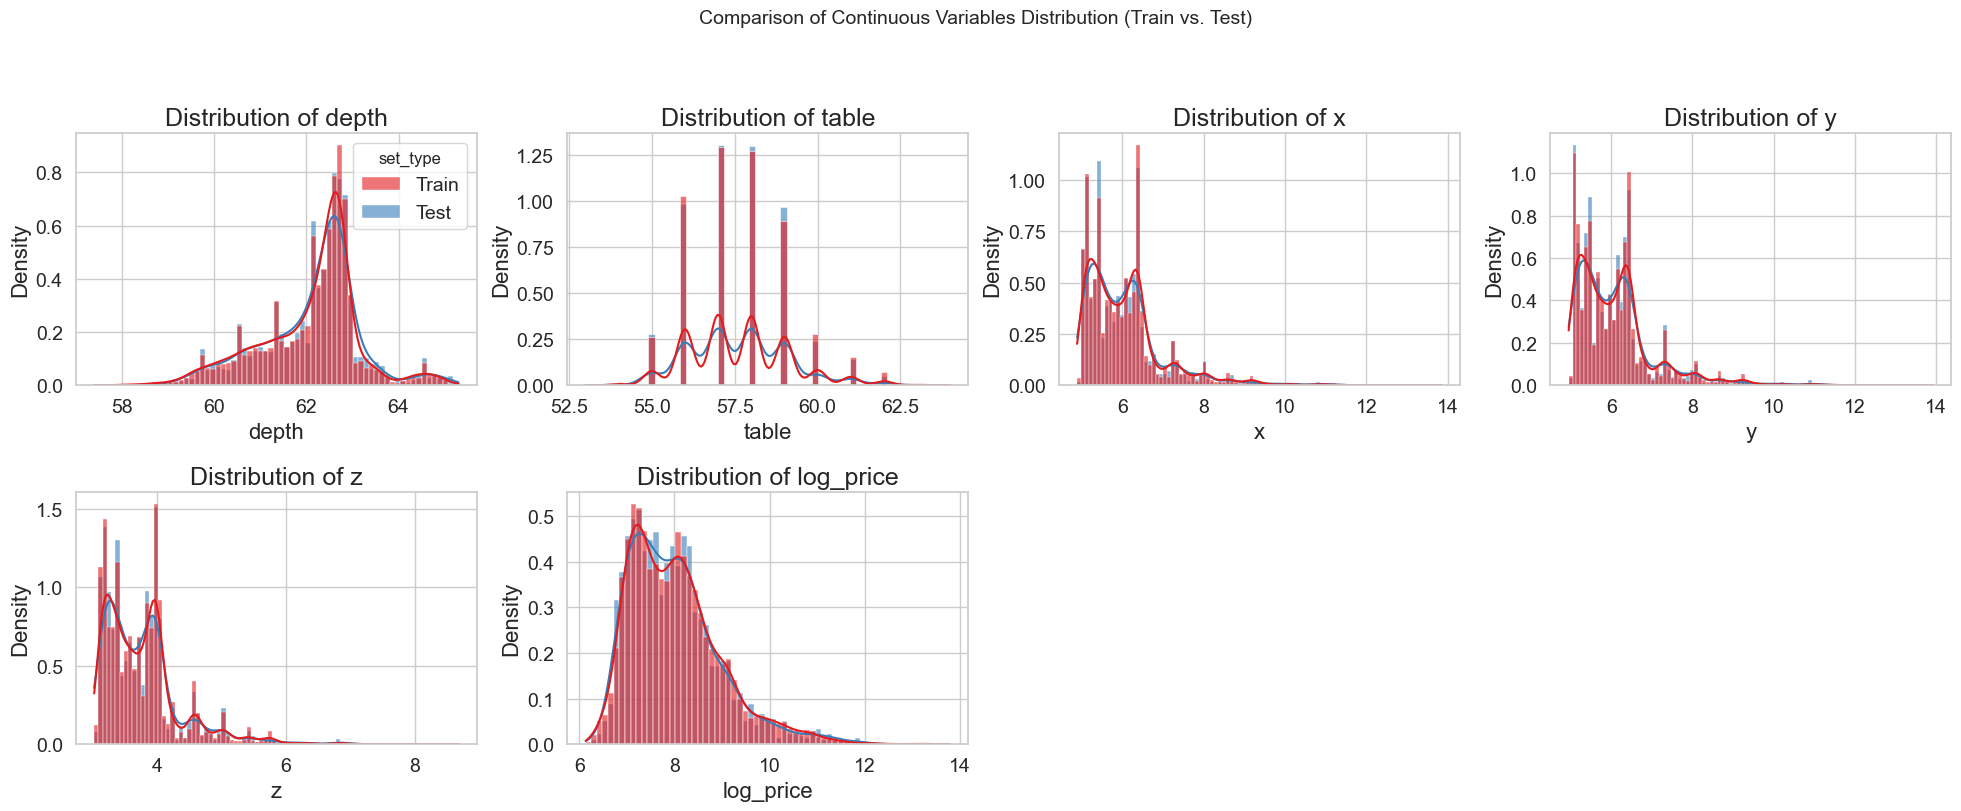


So sánh phân bố của biến danh mục giữa Train và Test set:


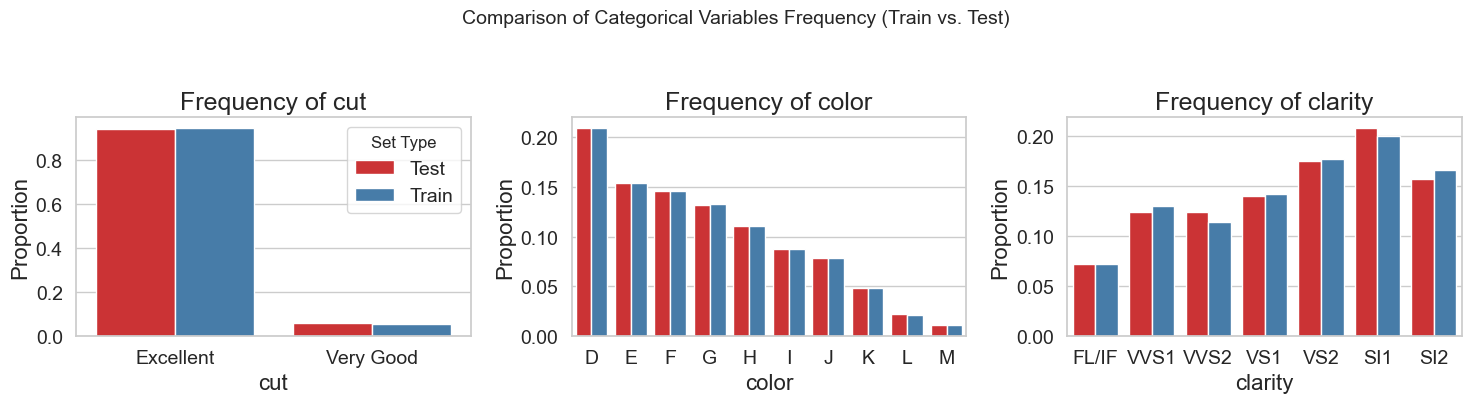

In [113]:
df_viz = df.copy() # Tạo một bản sao để thêm cột '_set_type' mà không ảnh hưởng đến df gốc

X = df_viz.drop(['price', 'log_price'], axis=1) # Các biến độc lập
y = df_viz['log_price'] # Biến mục tiêu

# Phân tầng theo 'color'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['color']
)

# Gắn lại biến mục tiêu vào X_train và X_test để dễ dàng visualize
X_train['log_price'] = y_train
X_test['log_price'] = y_test

# Thêm cột nhận dạng 'set_type' vào mỗi tập để phân biệt khi vẽ
X_train['set_type'] = 'Train'
X_test['set_type'] = 'Test'

# Nối lại X_train và X_test để vẽ biểu đồ so sánh dễ dàng hơn
combined_df = pd.concat([X_train, X_test])  
# --- Danh sách các biến để vẽ biểu đồ ---
categorical_vars = ['cut', 'color', 'clarity']
continuous_vars = ['depth', 'table', 'x','y','z', 'log_price']

# --- Đặt lại kích thước font cho các nhãn biểu đồ ---


# --- Cài đặt palette màu sắc tương phản rõ ràng ---
custom_palette = sns.color_palette("Set1", n_colors=2) # Ví dụ: màu đỏ và xanh

# --- Vẽ biểu đồ cho biến liên tục (Histogram) trên cùng một Figure ---
print("So sánh phân bố của biến liên tục giữa Train và Test set:")
# Xác định số lượng hàng và cột cho subplot
num_cont_vars = len(continuous_vars)
n_cols_cont = 4 # Số cột bạn muốn hiển thị
n_rows_cont = (num_cont_vars + n_cols_cont - 1) // n_cols_cont # Tính số hàng cần thiết

fig_cont, axes_cont = plt.subplots(n_rows_cont, n_cols_cont, figsize=(5 * n_cols_cont, 4 * n_rows_cont))
axes_cont = axes_cont.flatten() # Biến đổi mảng axes 2D thành 1D để dễ lặp

for i, var in enumerate(continuous_vars):
    ax = axes_cont[i]
    sns.histplot(data=combined_df, x=var, hue='set_type', kde=True, palette=custom_palette,
                 stat='density', common_norm=False, ax=ax, alpha=0.6) # Thêm alpha để dễ nhìn khi chồng lên
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    
    if i != 0: # Xóa legend ở các subplot còn lại sau khi đã đặt tiêu đề cho cái đầu tiên
            ax.get_legend().remove()

# Xóa các subplot trống nếu có
for j in range(i + 1, len(axes_cont)):
    fig_cont.delaxes(axes_cont[j])

plt.suptitle('Comparison of Continuous Variables Distribution (Train vs. Test)', y=1.02, fontsize=14) # Tiêu đề chung cho figure
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Điều chỉnh layout để không bị cắt tiêu đề
plt.show()

# --- Vẽ biểu đồ cho biến danh mục (Barplot với tần số) trên cùng một Figure ---
print("\nSo sánh phân bố của biến danh mục giữa Train và Test set:")
num_cat_vars = len(categorical_vars)
n_cols_cat = 3
n_rows_cat = (num_cat_vars + n_cols_cat - 1) // n_cols_cat

fig_cat, axes_cat = plt.subplots(n_rows_cat, n_cols_cat, figsize=(5 * n_cols_cat, 4 * n_rows_cat))
axes_cat = axes_cat.flatten()

for i, var in enumerate(categorical_vars):
    ax = axes_cat[i]

    # Tính toán tần số (tỷ lệ phần trăm)
    # Group by var và set_type, sau đó tính số lượng và chuyển thành tỷ lệ
    df_freq = combined_df.groupby('set_type')[var].value_counts(normalize=True).rename('proportion').reset_index()

    # Sắp xếp các cấp độ cho dễ nhìn nếu là biến ordinal
    order = None
    if var == 'color':
        order = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
    elif var == 'clarity':
        order = ['FL/IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2'] # Đảm bảo thêm I1, I2, I3 nếu có
    elif var == 'cut':
        order = ['Excellent', 'Very Good'] # Đảm bảo thêm các loại khác nếu có

    sns.barplot(data=df_freq, x=var, y='proportion', hue='set_type', palette=custom_palette, order=order, ax=ax)
    ax.set_title(f'Frequency of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Proportion')
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') # Xoay nhãn nếu cần
    if i == 0: # Chỉ hiển thị legend cho subplot đầu tiên
        ax.legend(title='Set Type')
    else:
        ax.get_legend().remove() # Xóa legend ở các subplot còn lại

# Xóa các subplot trống nếu có
for j in range(i + 1, len(axes_cat)):
    fig_cat.delaxes(axes_cat[j])

plt.suptitle('Comparison of Categorical Variables Frequency (Train vs. Test)', y=1.02, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [114]:
df.drop(columns=['log_price'], inplace=True)  # Xoá cột log_price sau khi đã sử dụng

In [115]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['color']
)


In [116]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [117]:
df_train.to_csv('clean_data_train.csv', index=False)
df_test.to_csv('clean_data_test.csv', index=False)

## DATA ENGINEERING

### BIẾN MỤC TIÊU - PRICE
#### ✅ Ưu điểm sau log-transform:

| **Yếu tố**              | **Trước log-transform (price)** | **Sau log-transform (log(price))**     |
|-------------------------|----------------------------------|----------------------------------------|
| **Skewness**            | Lệch phải mạnh                   | Gần chuẩn hơn                          |
| **Hiển thị chi tiết**   | Bị nén phần thấp                 | Trải đều, dễ nhìn hơn                  |
| **Quan sát phân cụm**   | Không rõ ràng                    | Có thể thấy được **2 cụm giá**         |

* Một mode chính nằm khoảng log(price) ≈ 7.5 (tương đương với khoảng 1,800 USD).

* Một mode phụ nhỏ hơn ở khoảng log(price) ≈ 8.5 (tương đương 5,000 USD).




In [118]:
df_train['log_price'] = np.log(df_train['price'])

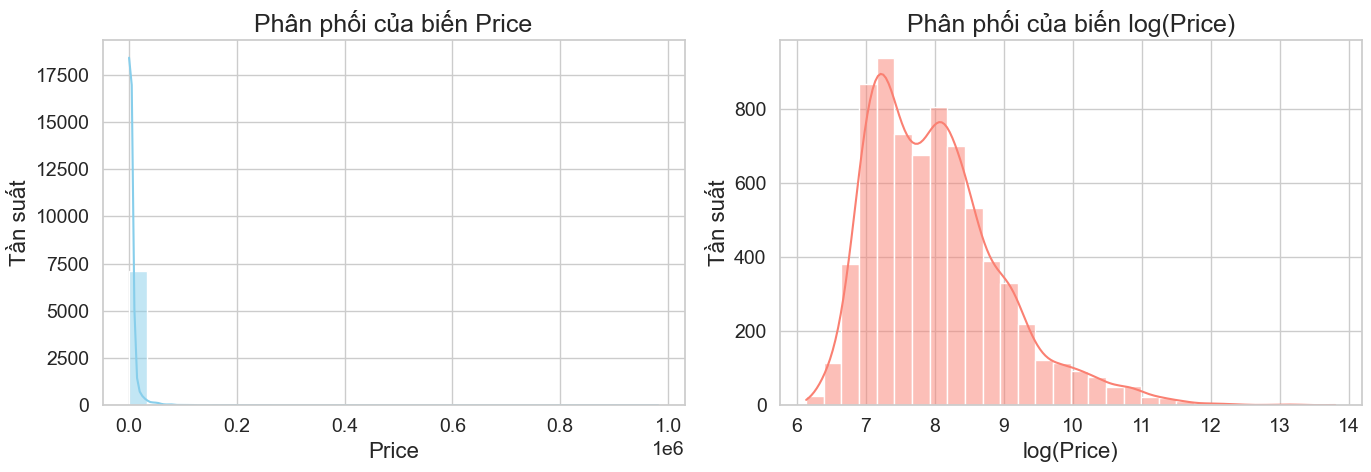

In [119]:
# Vẽ 2 biểu đồ cạnh nhau
plt.figure(figsize=(14, 5))

# Biểu đồ gốc - Price
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='price', kde=True, bins=30, color='skyblue')
plt.title('Phân phối của biến Price')
plt.xlabel('Price')
plt.ylabel('Tần suất')

# Biểu đồ log-transform
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='log_price', kde=True, bins=30, color='salmon')
plt.title('Phân phối của biến log(Price)')
plt.xlabel('log(Price)')
plt.ylabel('Tần suất')

plt.tight_layout()
plt.show()


### TRỰC QUAN MỐI LIÊN HỆ BIẾN DANH MỤC - PRICE

#### COUNTPLOT CHO BIẾN DANH MỤC

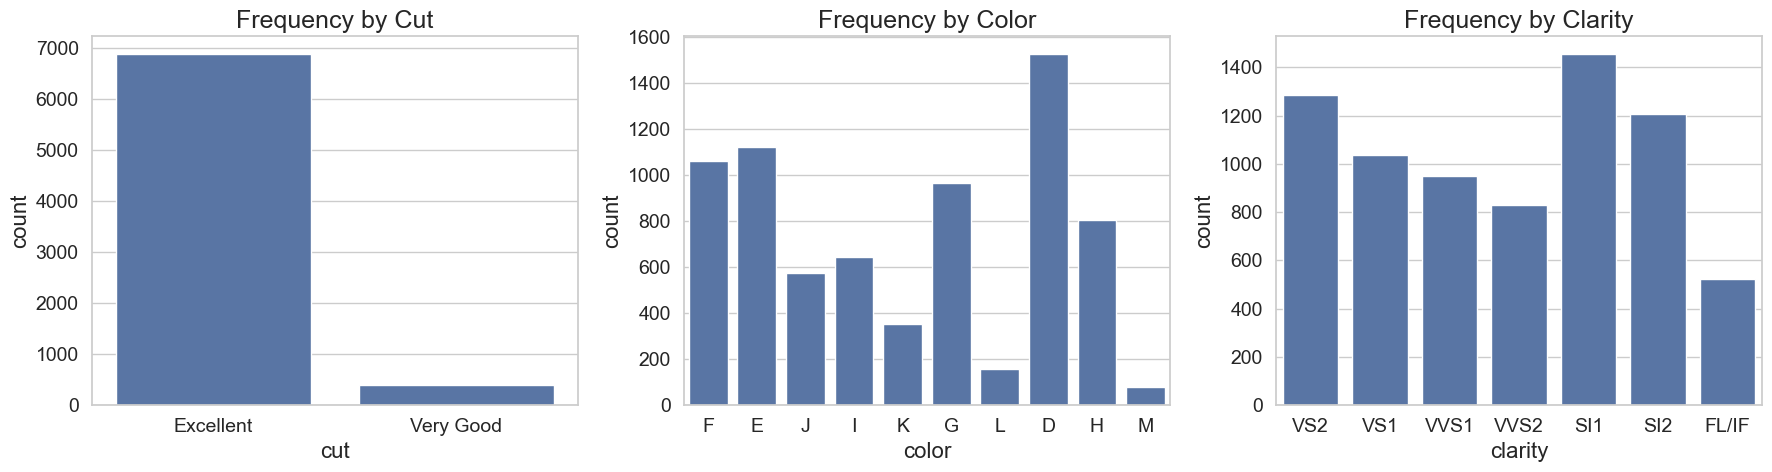

In [120]:

plt.figure(figsize=(18, 5))

# Countplot theo 'cut'
plt.subplot(1, 3, 1)
sns.countplot(data=df_train, x='cut')
plt.title('Frequency by Cut')

# Countplot theo 'color'
plt.subplot(1, 3, 2)
sns.countplot(data=df_train, x='color')
plt.title('Frequency by Color')

# Countplot theo 'clarity'
plt.subplot(1, 3, 3)
sns.countplot(data=df_train, x='clarity')
plt.title('Frequency by Clarity')

plt.tight_layout()
plt.show()



#### BIẾN DANH MỤC - LOG(PRICE)

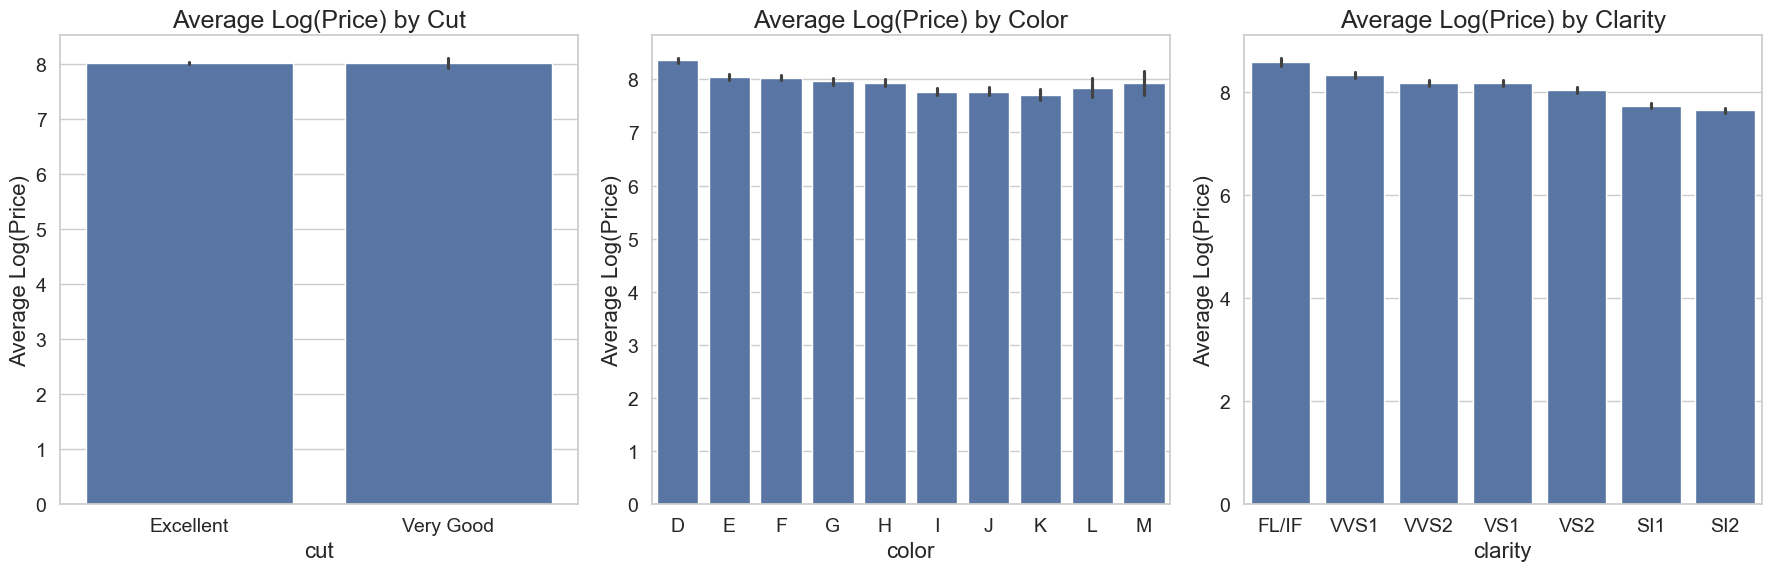

In [121]:
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
clarity_order = ['FL/IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2']
plt.figure(figsize=(18, 6))

# Barplot của trung bình log(price) theo 'cut'
plt.subplot(1, 3, 1)
sns.barplot(data=df_train, x='cut', y='log_price', estimator=np.mean)
plt.title('Average Log(Price) by Cut')
plt.ylabel('Average Log(Price)')

# Barplot của trung bình log(price) theo 'color'
plt.subplot(1, 3, 2)
sns.barplot(data=df_train, x='color', y='log_price', estimator=np.mean, order=color_order)
plt.title('Average Log(Price) by Color')
plt.ylabel('Average Log(Price)')

# Barplot của trung bình log(price) theo 'clarity'
plt.subplot(1, 3, 3)
sns.barplot(data=df_train, x='clarity', y='log_price', estimator=np.mean,  order=clarity_order)
plt.title('Average Log(Price) by Clarity')
plt.ylabel('Average Log(Price)')

plt.tight_layout()
plt.show()

### TRỰC QUAN MỐI QUAN HỆ GIỮA BIẾN LIÊN TỤC - PRICE 

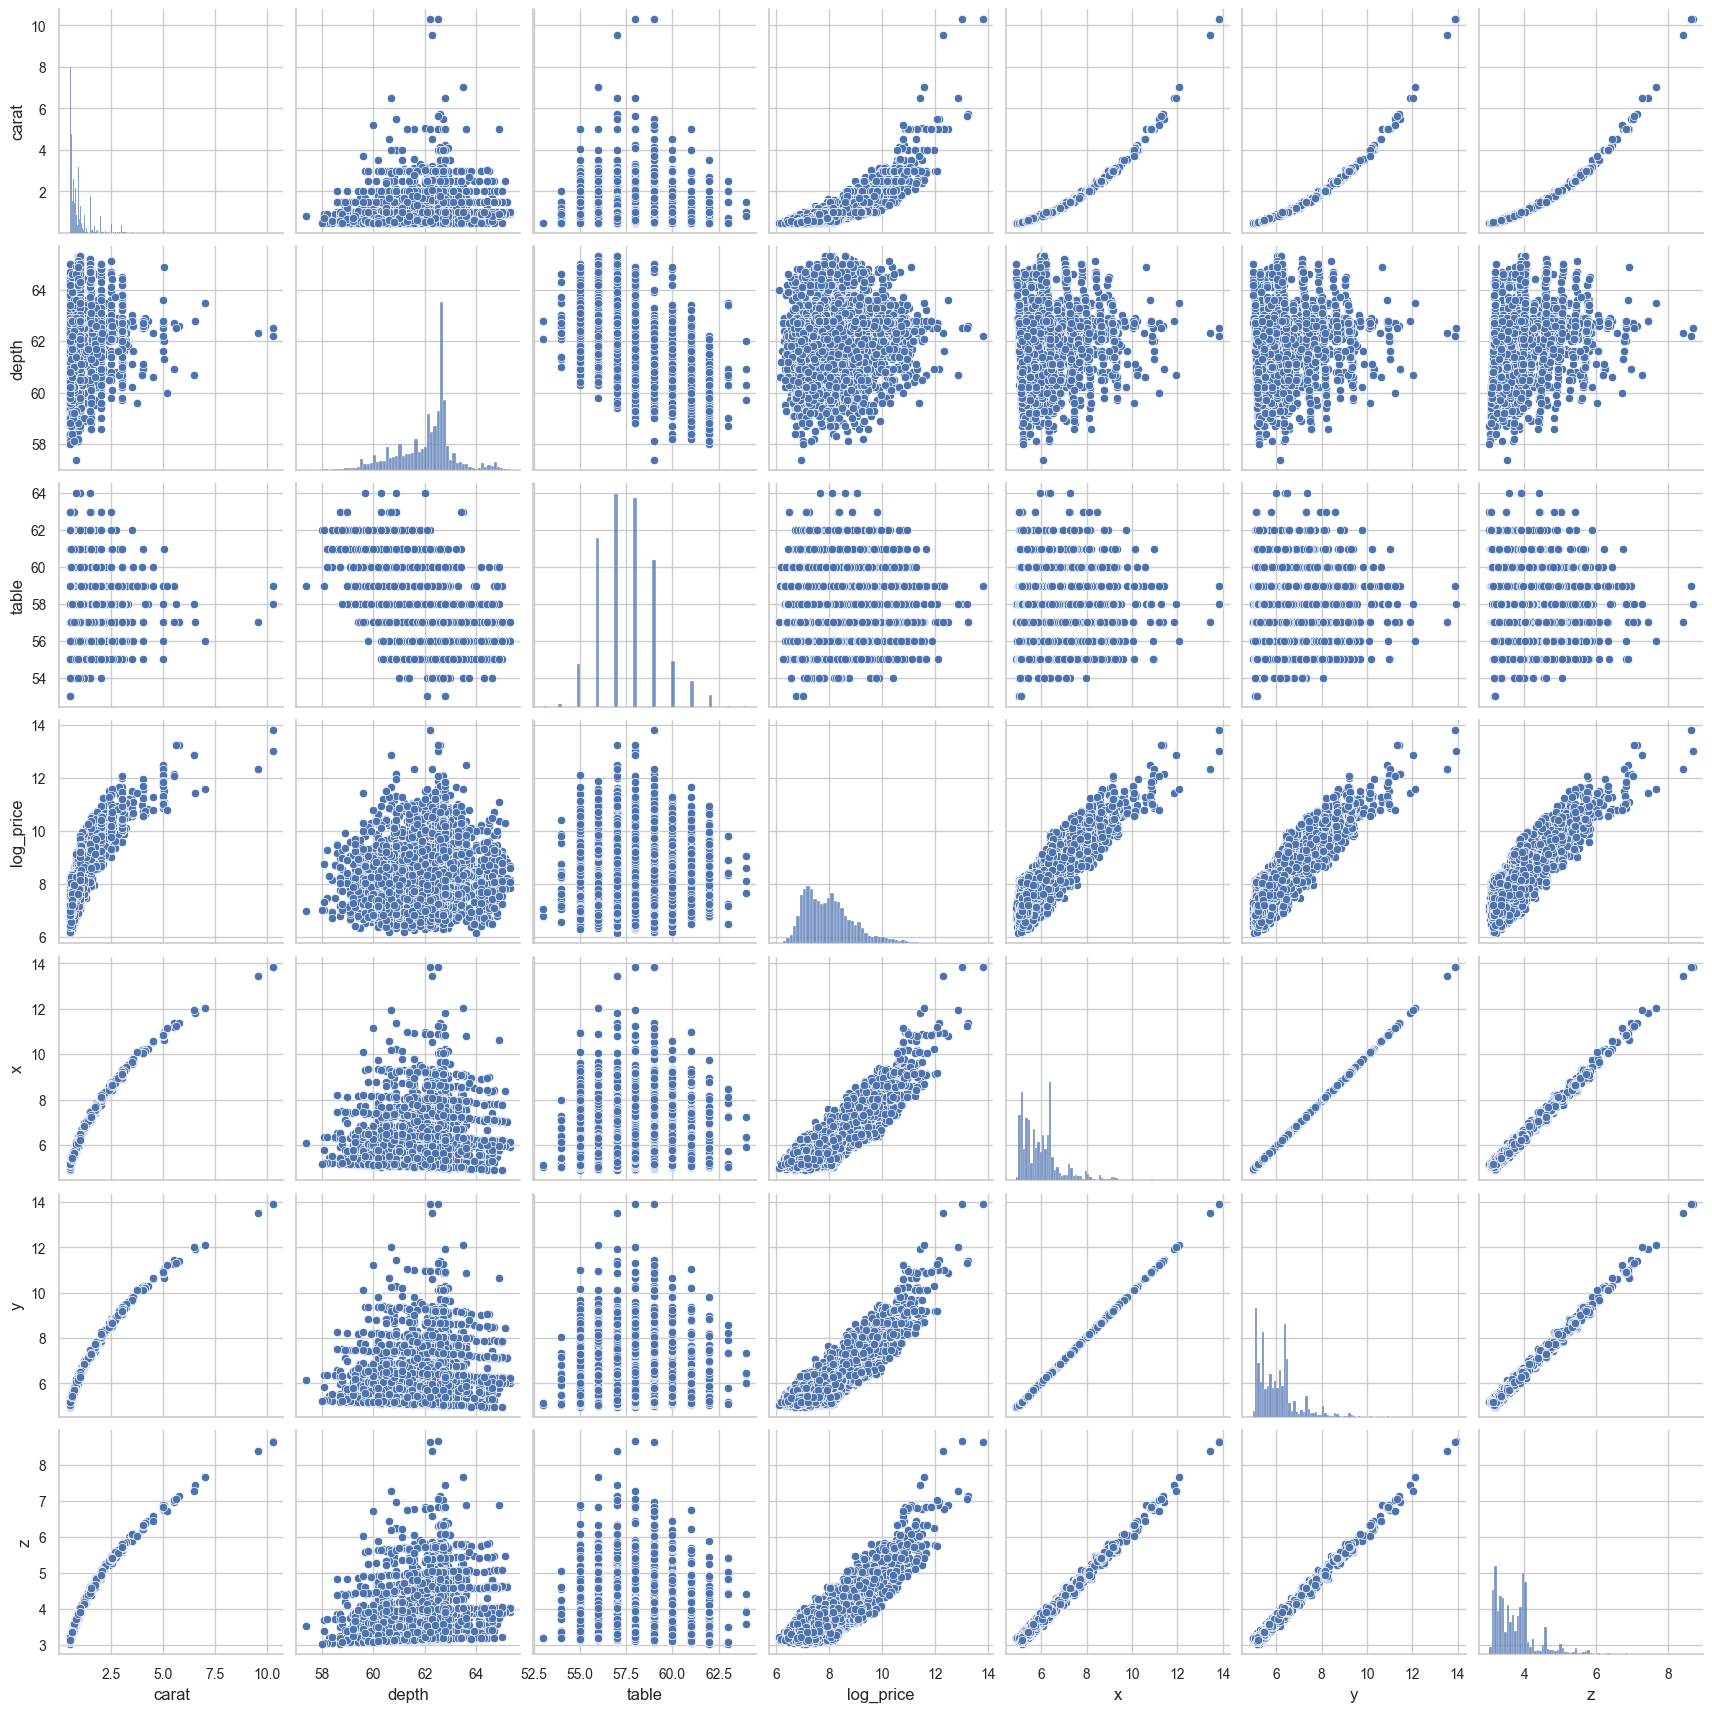

In [122]:
# Chọn các cột liên tục


plt.rcParams['axes.labelsize'] = 12 # Kích thước font cho nhãn trục x và y
plt.rcParams['xtick.labelsize'] = 10 # Kích thước font cho các số trên trục x
plt.rcParams['ytick.labelsize'] = 10 # Kích thước font cho các số trên trục y
continuous_vars = ['carat', 'depth', 'table', 'log_price', 'x', 'y', 'z']
sns.pairplot(df_train[continuous_vars])
plt.show()



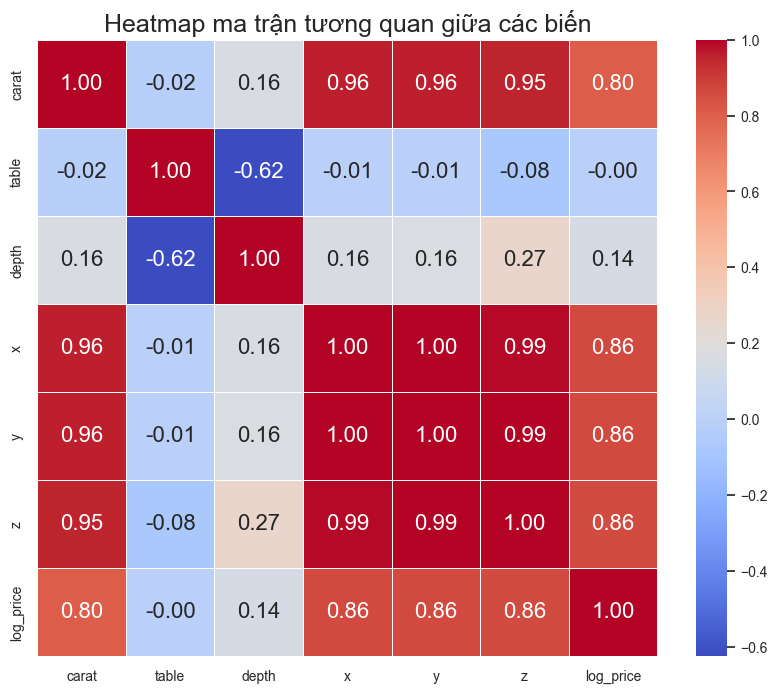

In [123]:


# Tính ma trận tương quan
corr = df_train.drop(['price'],axis =1).corr(numeric_only=True)

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap ma trận tương quan giữa các biến')
plt.show()


### VẤN ĐỀ ĐA CỘNG TUYẾN (CARAT,X,Y,Z)

In [124]:


# Giả sử df là DataFrame chứa dữ liệu của bạn
df_MCL = df_train[['carat','x','y','z']]

# Thêm cột hằng số (intercept)


In [125]:
vif_data = pd.DataFrame()
vif_data["Variable"] = df_MCL.columns
vif_data["VIF"] = [variance_inflation_factor(df_MCL.values, i)
                   for i in range(df_MCL.shape[1])]

print(vif_data)

  Variable            VIF
0    carat       6.449352
1        x  264980.635469
2        y  286008.760419
3        z    3714.791113


#### QUYẾT ĐỊNH GIỮ LẠI BIẾN X VÀ LOẠI BỎ ĐI CARAT,Y,Z
* X có tương quan tuyến tính cao hơn so với CARAT
* Loại bỏ đi CARAT,Y,Z để tránh dư thừa cũng như các ảnh hưởng của đa cộng tuyến đến mô hình 

In [126]:
df_train.drop(columns=["carat", "y", "z"], inplace=True)

In [127]:
df_train.head()

,color,clarity,cut,table,depth,x,price,log_price
4101,F,VS2,Excellent,62.0,62.0,5.04,1401.0,7.244942
3146,F,VS1,Excellent,56.0,62.3,5.33,1467.0,7.290975
7106,E,VVS1,Excellent,58.0,62.7,5.10,2282.0,7.732808
1892,F,VVS2,Excellent,60.0,60.2,6.51,8483.0,9.045819
721,J,VVS1,Excellent,59.0,60.0,5.44,1215.0,7.102499


### Data Encoding and Normalization

In [128]:
X_train =df_train.drop(['price', 'log_price'], axis=1)
y_train = df_train['log_price']

In [129]:
numerical_cols = ['depth', 'table', 'x']
categorical_cols = ['cut', 'color', 'clarity']

In [130]:
cut_categories = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
color_categories = ['M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D'] # Từ kém nhất (0) đến tốt nhất (9)
clarity_categories = ['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'FL/IF'] # Từ kém nhất (0) đến tốt nhất (6)
scaler = StandardScaler()
# Khởi tạo OrdinalEncoder cho từng cột danh mục
# Chúng ta sẽ xử lý từng cột riêng biệt
encoder_cut = OrdinalEncoder(categories=[cut_categories], handle_unknown='use_encoded_value', unknown_value=-1)
encoder_color = OrdinalEncoder(categories=[color_categories], handle_unknown='use_encoded_value', unknown_value=-1)
encoder_clarity = OrdinalEncoder(categories=[clarity_categories], handle_unknown='use_encoded_value', unknown_value=-1)
# 2. FIT (Học tham số) trên X_train và TRANSFORM cho cả X_train và X_test
# --- Xử lý biến liên tục ---
# Fit scaler trên X_train của các cột số
scaler.fit(X_train[numerical_cols])

# Transform X_train và X_test sử dụng scaler đã fit
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
# --- Xử lý biến danh mục ---
# Fit và Transform cho 'cut'
encoder_cut.fit(X_train[['cut']])
X_train['cut'] = encoder_cut.transform(X_train[['cut']])
# Fit và Transform cho 'color'
encoder_color.fit(X_train[['color']])
X_train['color'] = encoder_color.transform(X_train[['color']])
# Fit và Transform cho 'clarity'
encoder_clarity.fit(X_train[['clarity']])
X_train['clarity'] = encoder_clarity.transform(X_train[['clarity']])

In [131]:
X_train.head()

,color,clarity,cut,table,depth,x
4101,7.0,2.0,4.0,2.885633,-0.087444,-1.071687
3146,7.0,3.0,4.0,-1.073406,0.187454,-0.763070
7106,8.0,5.0,4.0,0.246274,0.553986,-1.007835
1892,7.0,4.0,4.0,1.565953,-1.736837,0.492683
721,3.0,5.0,4.0,0.906114,-1.920103,-0.646008


In [132]:
y_train.head()

4101    7.244942
3146    7.290975
7106    7.732808
1892    9.045819
721     7.102499
Name: log_price, dtype: float64

## ÁP DỤNG DATA ENGINEERING AND ENCODING & NORMALIZATION CHO TẬP TEST 

In [133]:
df_test.head()

,carat,color,clarity,cut,table,depth,x,y,z,price
10048,1.00,J,SI2,Excellent,59.0,61.9,6.40,6.43,3.97,1847.0
9120,5.31,L,SI1,Excellent,56.0,61.8,11.17,11.21,6.91,55729.0
9074,0.90,E,SI1,Very Good,62.0,62.8,6.02,6.10,3.81,2826.0
10259,0.59,D,SI1,Excellent,57.0,62.6,5.34,5.37,3.35,1316.0
9891,0.59,F,SI1,Excellent,59.0,59.6,5.46,5.48,3.26,1053.0


In [134]:
df_test['log_price'] = np.log(df_test['price'])

In [135]:
X_test = df_test.drop(['price', 'log_price'], axis=1)
y_test = df_test['log_price']

In [136]:
X_test.head()

,carat,color,clarity,cut,table,depth,x,y,z
10048,1.00,J,SI2,Excellent,59.0,61.9,6.40,6.43,3.97
9120,5.31,L,SI1,Excellent,56.0,61.8,11.17,11.21,6.91
9074,0.90,E,SI1,Very Good,62.0,62.8,6.02,6.10,3.81
10259,0.59,D,SI1,Excellent,57.0,62.6,5.34,5.37,3.35
9891,0.59,F,SI1,Excellent,59.0,59.6,5.46,5.48,3.26


In [137]:
X_test.drop(columns=["carat", "y", "z"], inplace=True)
# --- Xử lý biến liên tục ---
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
# --- Xử lý biến danh mục ---
# Transform cho 'cut'
X_test['cut'] = encoder_cut.transform(X_test[['cut']])
# Transform cho 'color'
X_test['color'] = encoder_color.transform(X_test[['color']])
# Transform cho 'clarity'
X_test['clarity'] = encoder_clarity.transform(X_test[['clarity']])
X_test.head()

,color,clarity,cut,table,depth,x
10048,3.0,0.0,4.0,0.906114,-0.179077,0.375621
9120,1.0,1.0,4.0,-1.073406,-0.270710,5.451842
9074,8.0,1.0,3.0,2.885633,0.645619,-0.028773
10259,9.0,1.0,4.0,-0.413566,0.462353,-0.752428
9891,7.0,1.0,4.0,0.906114,-2.286635,-0.624724


In [138]:
y_test.head()

10048     7.521318
9120     10.928256
9074      7.946618
10259     7.182352
9891      6.959399
Name: log_price, dtype: float64

## HUẤN LUYỆN MÔ HÌNH HỒI QUY

### LỰA CHỌN MÔ HÌNH

#### RANDOMFOREST

In [139]:
rf = RandomForestRegressor(random_state=42)

# Định nghĩa lưới siêu tham số
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                              cv=5, scoring='neg_mean_squared_error',
                              verbose=1, n_jobs=-1)

# Huấn luyện
grid_search_rf.fit(X_train, y_train)

# Kết quả tốt nhất
print("✅ Best params:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

C:\Users\quock\AppData\Local\Temp\ipykernel_40392\3305210008.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


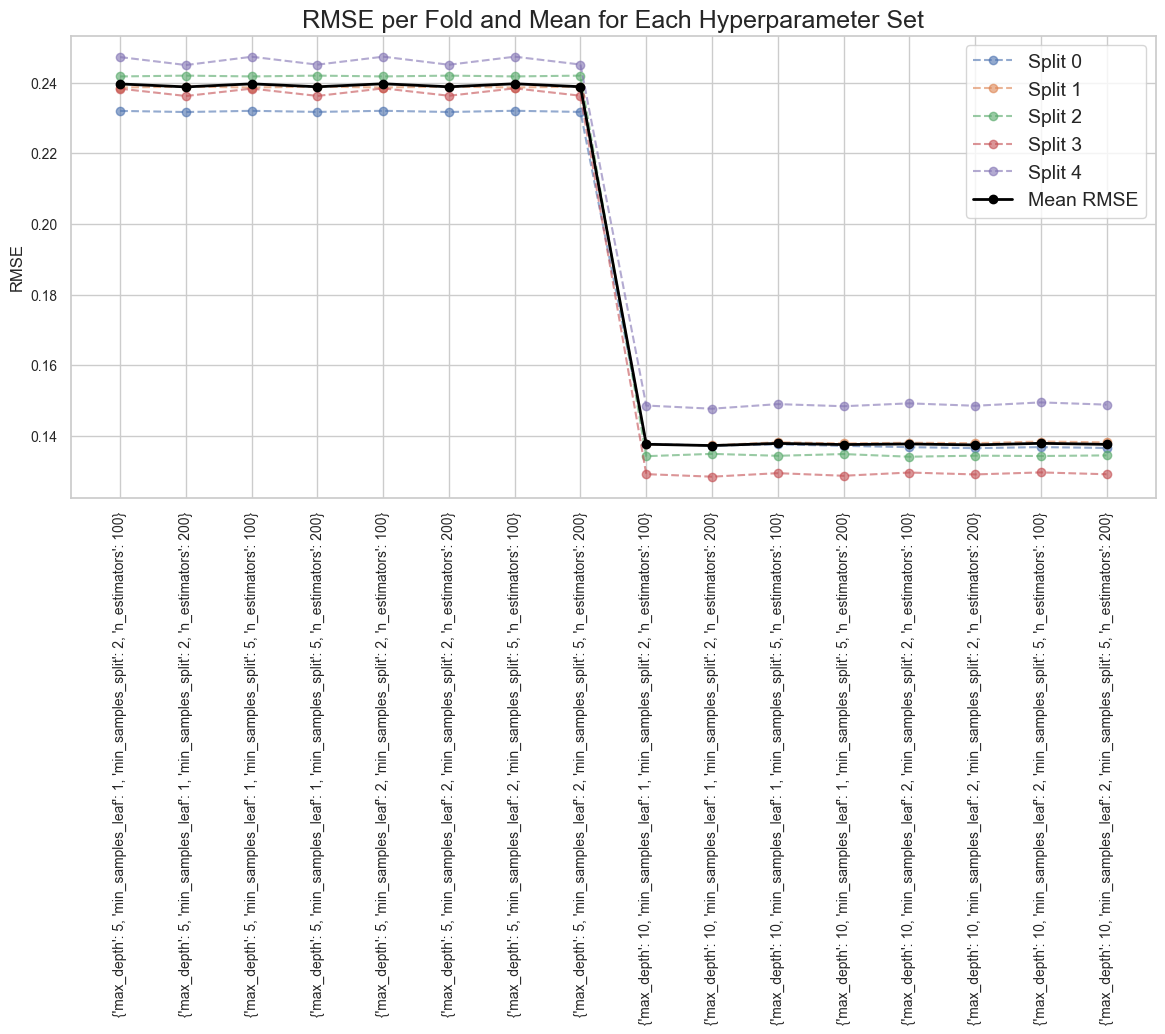

In [140]:
cv_results = pd.DataFrame(grid_search_rf.cv_results_)

# Thêm tên param_set để hiển thị trên trục x
cv_results['param_set'] = cv_results['params'].apply(lambda x: str(x))

# Đổi neg_mean_squared_error về RMSE
for i in range(grid_search_rf.cv):
    cv_results[f'split{i}_rmse'] = np.sqrt(-cv_results[f'split{i}_test_score'])

cv_results['mean_rmse'] = np.sqrt(-cv_results['mean_test_score'])
plt.figure(figsize=(14, 6))

# Vẽ từng fold
for i in range(grid_search_rf.cv):
    plt.plot(cv_results['param_set'], cv_results[f'split{i}_rmse'],
             marker='o', linestyle='--', alpha=0.6, label=f'Split {i}')

# Vẽ RMSE trung bình
plt.plot(cv_results['param_set'], cv_results['mean_rmse'],
         marker='o', color='black', linewidth=2, label='Mean RMSE')

plt.xticks(rotation=90)
plt.ylabel('RMSE')
plt.title('RMSE per Fold and Mean for Each Hyperparameter Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [141]:
y_pred_rf = best_rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"📉 RMSE on test set: {rmse_rf:.2f}")
print(f"📈 R² on test set: {r2_rf:.4f}")

y_pred_true_rf = np.exp(y_pred_rf)
y_test_exp = np.exp(y_test)  
rmse_true_rf = np.sqrt(mean_squared_error(y_test_exp, y_pred_rf))
r2_true_rf = r2_score(y_test_exp, y_pred_rf)
print(f"📉 RMSE on test set (true scale): {rmse_true_rf:.2f}")
print(f"📈 R² on test set (true scale): {r2_true_rf:.4f}")

📉 RMSE on test set: 0.14
📈 R² on test set: 0.9789
📉 RMSE on test set (true scale): 13754.51
📈 R² on test set (true scale): -0.2085


#### XGBOOST

In [142]:
xgb = XGBRegressor(random_state=42)

# Định nghĩa lưới siêu tham số
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [ 5, 7,9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb,
                           cv=5, scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

# Huấn luyện
grid_search_xgb.fit(X_train, y_train)

# Kết quả tốt nhất
print("✅ Best params:", grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_
best_xgb.fit(X_train, y_train)



Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

C:\Users\quock\AppData\Local\Temp\ipykernel_40392\871243749.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


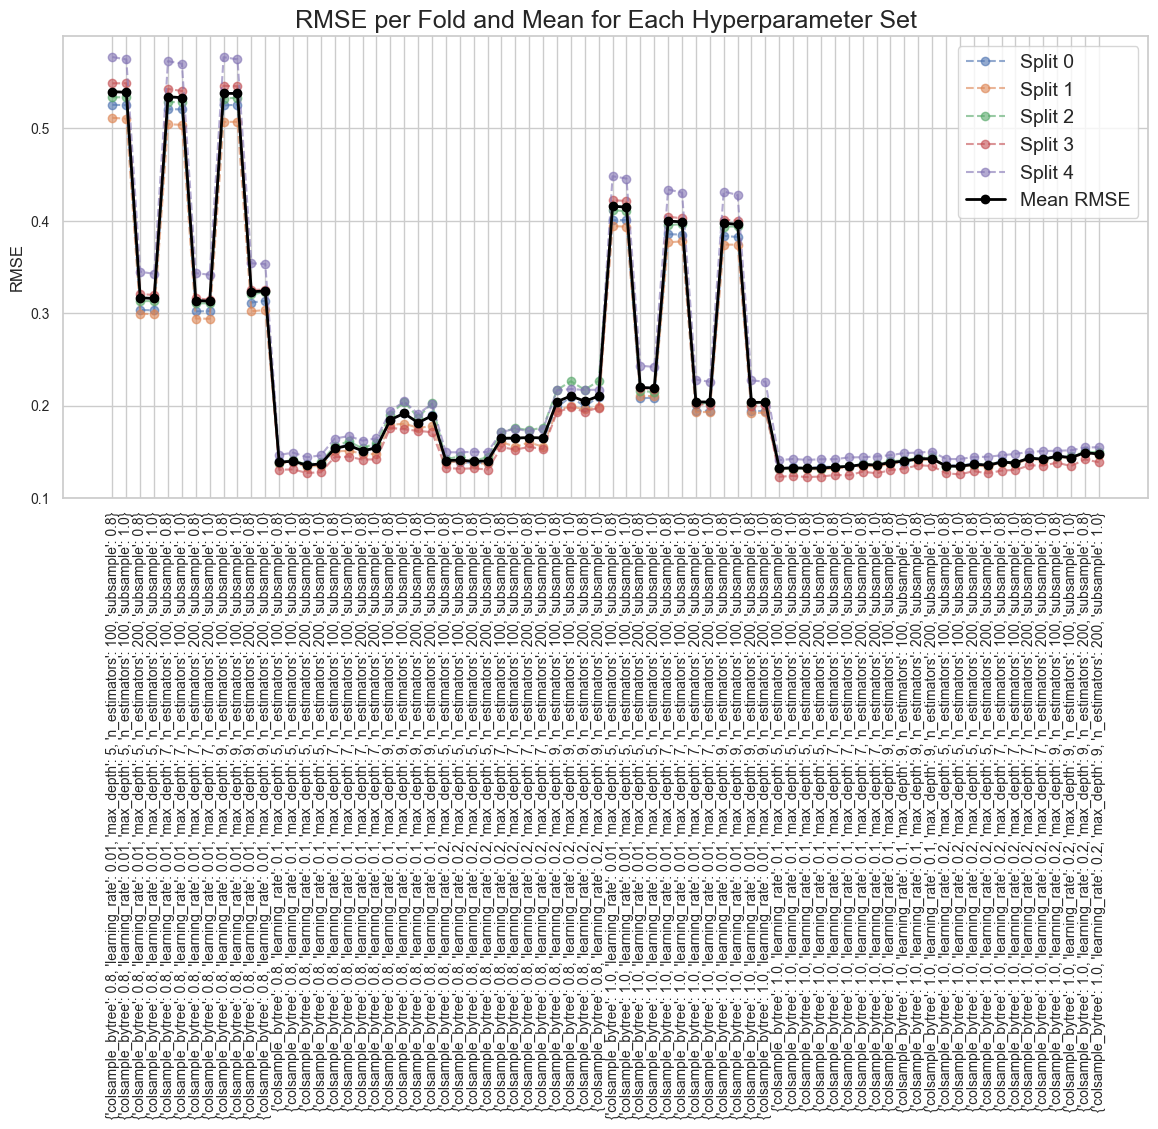

In [143]:
cv_results = pd.DataFrame(grid_search_xgb.cv_results_)

# Thêm tên param_set để hiển thị trên trục x
cv_results['param_set'] = cv_results['params'].apply(lambda x: str(x))

# Đổi neg_mean_squared_error về RMSE
for i in range(grid_search_xgb.cv):
    cv_results[f'split{i}_rmse'] = np.sqrt(-cv_results[f'split{i}_test_score'])

cv_results['mean_rmse'] = np.sqrt(-cv_results['mean_test_score'])
plt.figure(figsize=(14, 6))

# Vẽ từng fold
for i in range(grid_search_xgb.cv):
    plt.plot(cv_results['param_set'], cv_results[f'split{i}_rmse'],
             marker='o', linestyle='--', alpha=0.6, label=f'Split {i}')

# Vẽ RMSE trung bình
plt.plot(cv_results['param_set'], cv_results['mean_rmse'],
         marker='o', color='black', linewidth=2, label='Mean RMSE')

plt.xticks(rotation=90)
plt.ylabel('RMSE')
plt.title('RMSE per Fold and Mean for Each Hyperparameter Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
y_pred_xgb = best_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"📉 RMSE on test set: {rmse_xgb:.2f}")
print(f"📈 R² on test set: {r2_xgb:.4f}")

y_pred_true_xgb = np.exp(y_pred_xgb)
y_test_exp = np.exp(y_test)  
rmse_true_xgb = np.sqrt(mean_squared_error(y_test_exp, y_pred_true_xgb))
r2_true_xgb = r2_score(y_test_exp, y_pred_true_xgb)
print(f"📉 RMSE on test set (true scale): {rmse_true_xgb:.2f}")
print(f"📈 R² on test set (true scale): {r2_true_xgb:.4f}")

📉 RMSE on test set: 0.13
📈 R² on test set: 0.9806
📉 RMSE on test set (true scale): 4642.74
📈 R² on test set (true scale): 0.8623


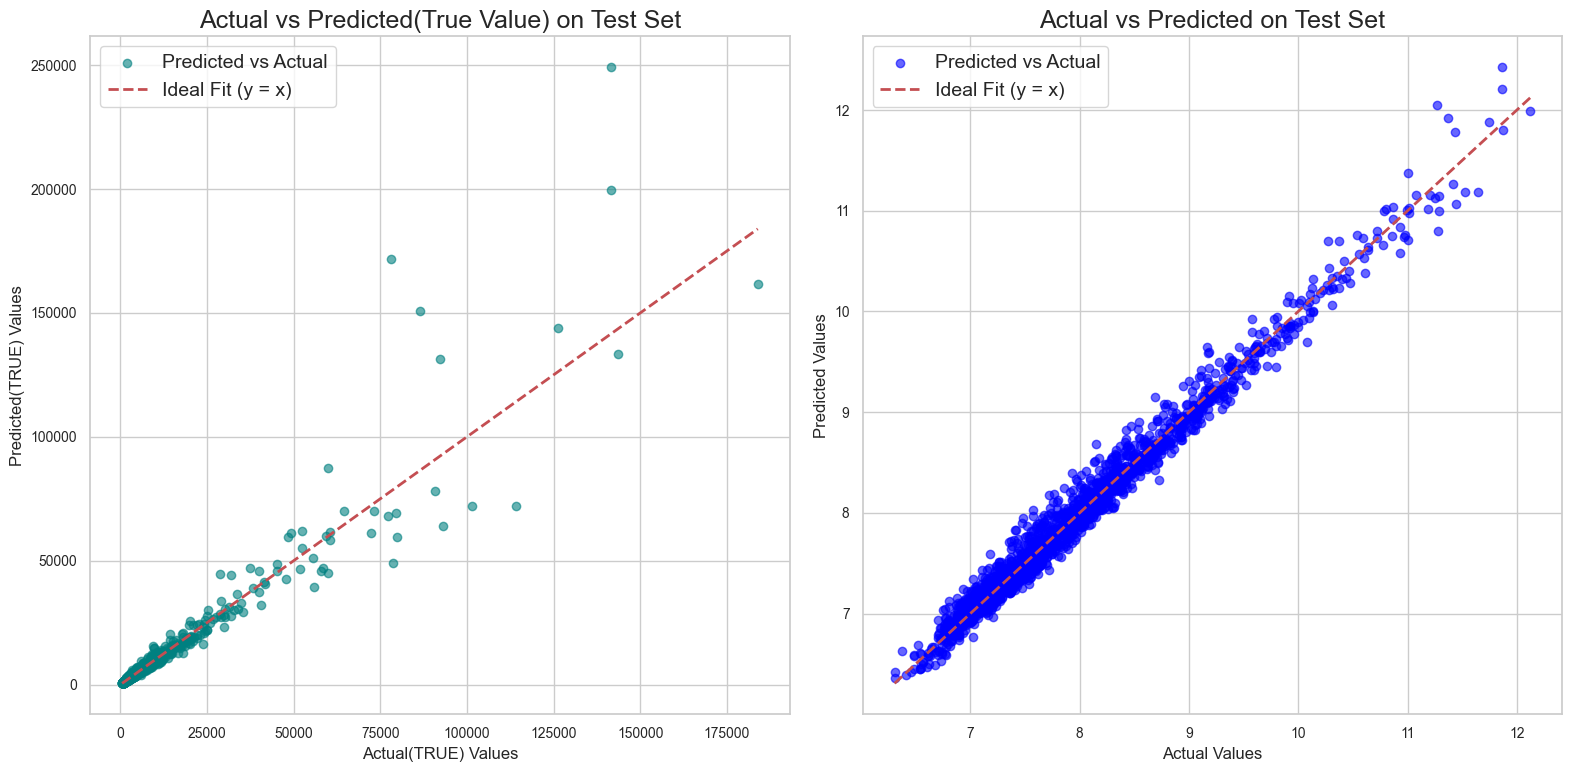

In [145]:

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(y_test_exp, y_pred_true_xgb, alpha=0.6, color='teal', label='Predicted vs Actual')
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], '--r', lw=2, label='Ideal Fit (y = x)')
plt.xlabel('Actual(TRUE) Values')
plt.ylabel('Predicted(TRUE) Values')
plt.title('Actual vs Predicted(True Value) on Test Set')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Ideal Fit (y = x)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted on Test Set')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()




#### LIGHTGBM

In [146]:
lgbm = lgb.LGBMRegressor(random_state=42)

# Định nghĩa lưới siêu tham số
param_grid_lgbm = {
    'num_leaves': [31, 50],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm,
                               cv=5, scoring='neg_mean_squared_error',
                               verbose=1, n_jobs=-1)

# Huấn luyện
grid_search_lgbm.fit(X_train, y_train)

# Kết quả tốt nhất
print("✅ Best params:", grid_search_lgbm.best_params_)

# Mô hình với tham số tốt nhất
best_lgbm = grid_search_lgbm.best_estimator_

# Huấn luyện lại trên toàn bộ tập train
best_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 7285, number of used features: 6
[LightGBM] [Info] Start training from score 8.018613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMRegressor(colsample_bytree=0.8, max_depth=5, n_estimators=200,
              num_leaves=50, random_state=42, subsample=0.8)

C:\Users\quock\AppData\Local\Temp\ipykernel_40392\4285346462.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


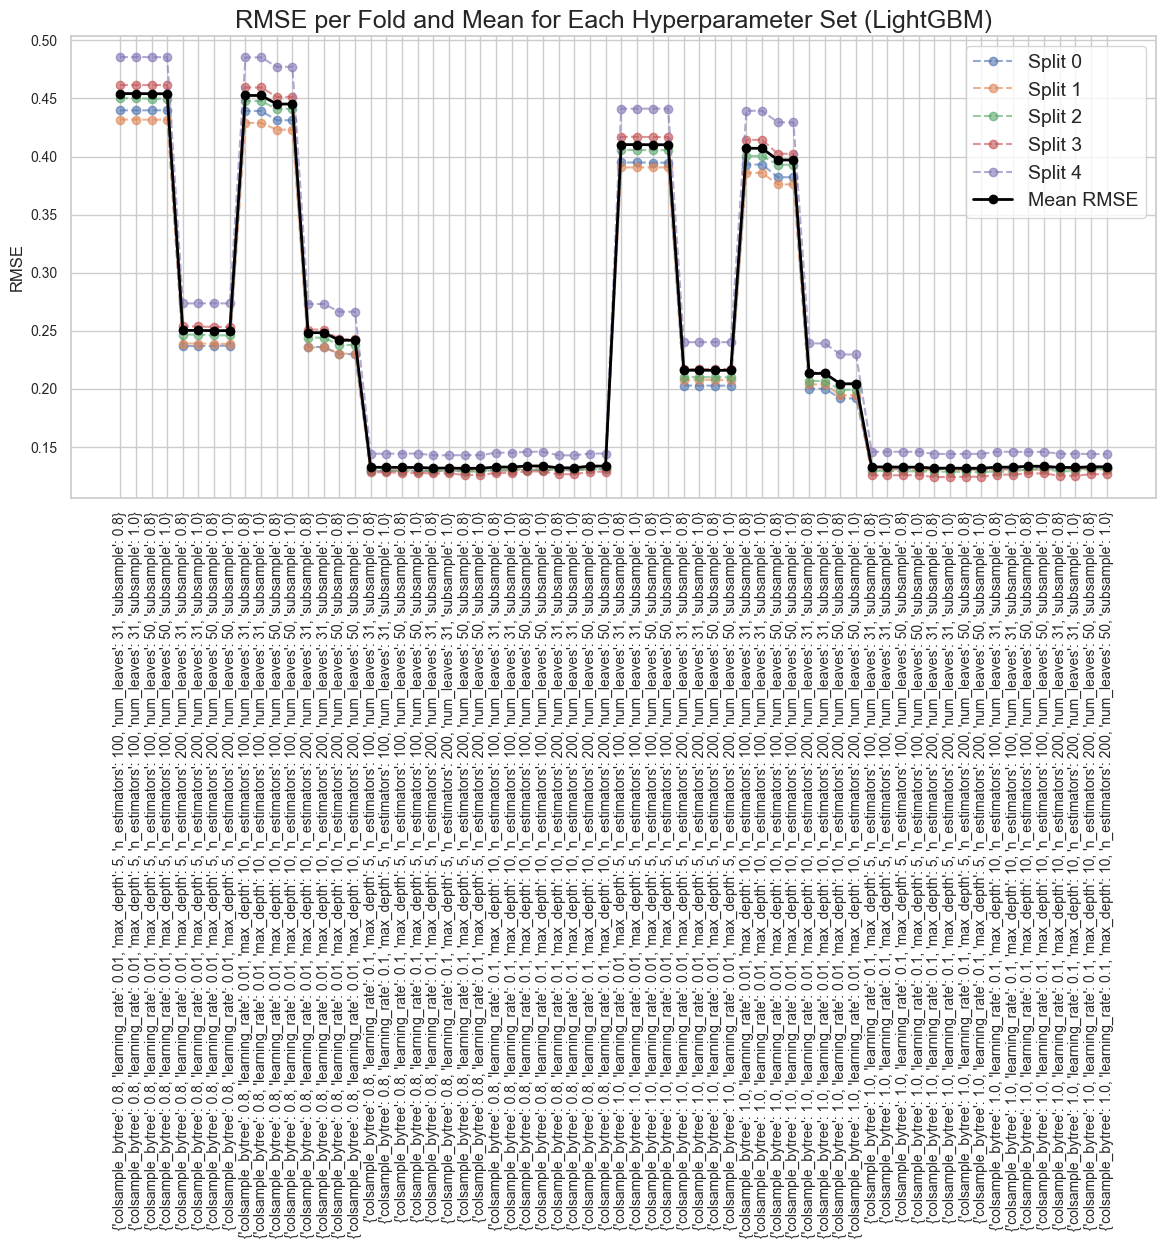

In [147]:
cv_results_lgbm = pd.DataFrame(grid_search_lgbm.cv_results_)

# Thêm cột param_set để hiển thị trên trục x
cv_results_lgbm['param_set'] = cv_results_lgbm['params'].apply(lambda x: str(x))

# Đổi neg_mean_squared_error về RMSE cho từng fold
for i in range(grid_search_lgbm.cv):
    cv_results_lgbm[f'split{i}_rmse'] = np.sqrt(-cv_results_lgbm[f'split{i}_test_score'])

# Tính RMSE trung bình (mean_test_score là neg_mean_squared_error)
cv_results_lgbm['mean_rmse'] = np.sqrt(-cv_results_lgbm['mean_test_score'])

plt.figure(figsize=(14, 6))

# Vẽ RMSE từng fold
for i in range(grid_search_lgbm.cv):
    plt.plot(cv_results_lgbm['param_set'], cv_results_lgbm[f'split{i}_rmse'],
             marker='o', linestyle='--', alpha=0.6, label=f'Split {i}')

# Vẽ RMSE trung bình
plt.plot(cv_results_lgbm['param_set'], cv_results_lgbm['mean_rmse'],
         marker='o', color='black', linewidth=2, label='Mean RMSE')

plt.xticks(rotation=90)
plt.ylabel('RMSE')
plt.title('RMSE per Fold and Mean for Each Hyperparameter Set (LightGBM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [148]:
# Dự đoán trên tập test (log scale)
y_pred_lgbm = best_lgbm.predict(X_test)

# Tính RMSE và R² trên log scale
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"📉 RMSE on test set (log scale): {rmse_lgbm:.2f}")
print(f"📈 R² on test set (log scale): {r2_lgbm:.4f}")

# Chuyển dự đoán và y_test về thang đo gốc bằng exp()
y_pred_true_lgbm = np.exp(y_pred_lgbm)
y_test_exp = np.exp(y_test)

# Tính RMSE và R² trên thang đo gốc (true scale)
rmse_true_lgbm = np.sqrt(mean_squared_error(y_test_exp, y_pred_true_lgbm))
r2_true_lgbm = r2_score(y_test_exp, y_pred_true_lgbm)

print(f"📉 RMSE on test set (true scale): {rmse_true_lgbm:.2f}")
print(f"📈 R² on test set (true scale): {r2_true_lgbm:.4f}")


📉 RMSE on test set (log scale): 0.13
📈 R² on test set (log scale): 0.9807
📉 RMSE on test set (true scale): 3939.42
📈 R² on test set (true scale): 0.9009


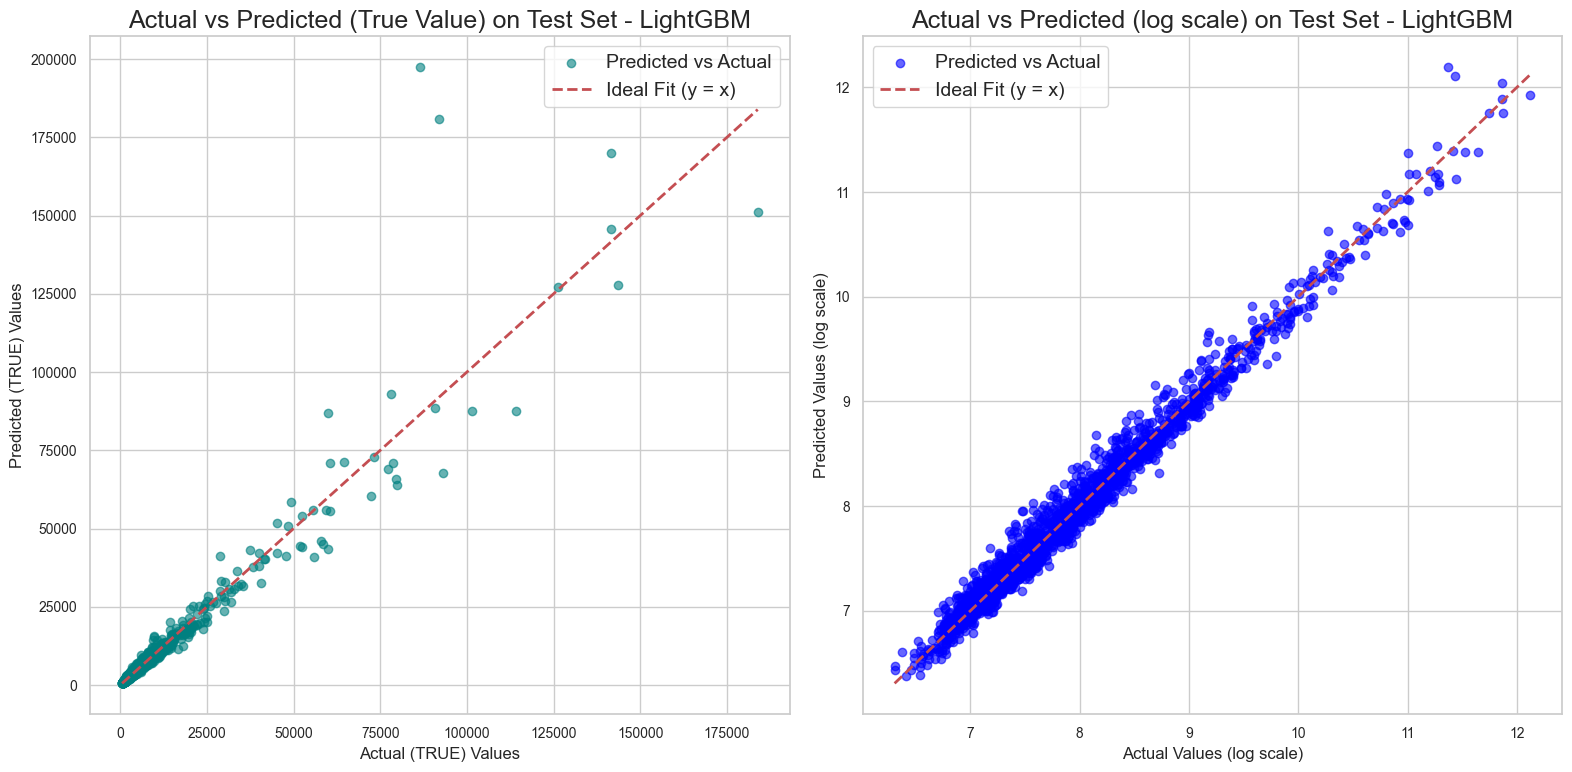

In [149]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(y_test_exp, np.exp(best_lgbm.predict(X_test)), alpha=0.6, color='teal', label='Predicted vs Actual')
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], '--r', lw=2, label='Ideal Fit (y = x)')
plt.xlabel('Actual (TRUE) Values')
plt.ylabel('Predicted (TRUE) Values')
plt.title('Actual vs Predicted (True Value) on Test Set - LightGBM')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, best_lgbm.predict(X_test), alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Ideal Fit (y = x)')
plt.xlabel('Actual Values (log scale)')
plt.ylabel('Predicted Values (log scale)')
plt.title('Actual vs Predicted (log scale) on Test Set - LightGBM')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### ĐÁNH GIÁ MÔ HÌNH

In [150]:
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost', 'LightGBM', 'LightGBM'],
    'Scale': ['log(price)', 'price', 'log(price)', 'price'],
    'RMSE': [rmse_xgb, rmse_true_xgb, rmse_lgbm, rmse_true_lgbm],
    'R2': [r2_xgb, r2_true_xgb, r2_lgbm, r2_true_lgbm]
})

print(metrics_df)


      Model       Scale         RMSE        R2
0   XGBoost  log(price)     0.132735  0.980559
1   XGBoost       price  4642.736770  0.862308
2  LightGBM  log(price)     0.132192  0.980718
3  LightGBM       price  3939.422311  0.900865


C:\Users\quock\AppData\Local\Temp\ipykernel_40392\487541137.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=metrics_df[metrics_df['Scale']=='log(price)'], x='Model', y='RMSE', palette='Set2')
C:\Users\quock\AppData\Local\Temp\ipykernel_40392\487541137.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=metrics_df[metrics_df['Scale']=='price'], x='Model', y='RMSE', palette='Set2')


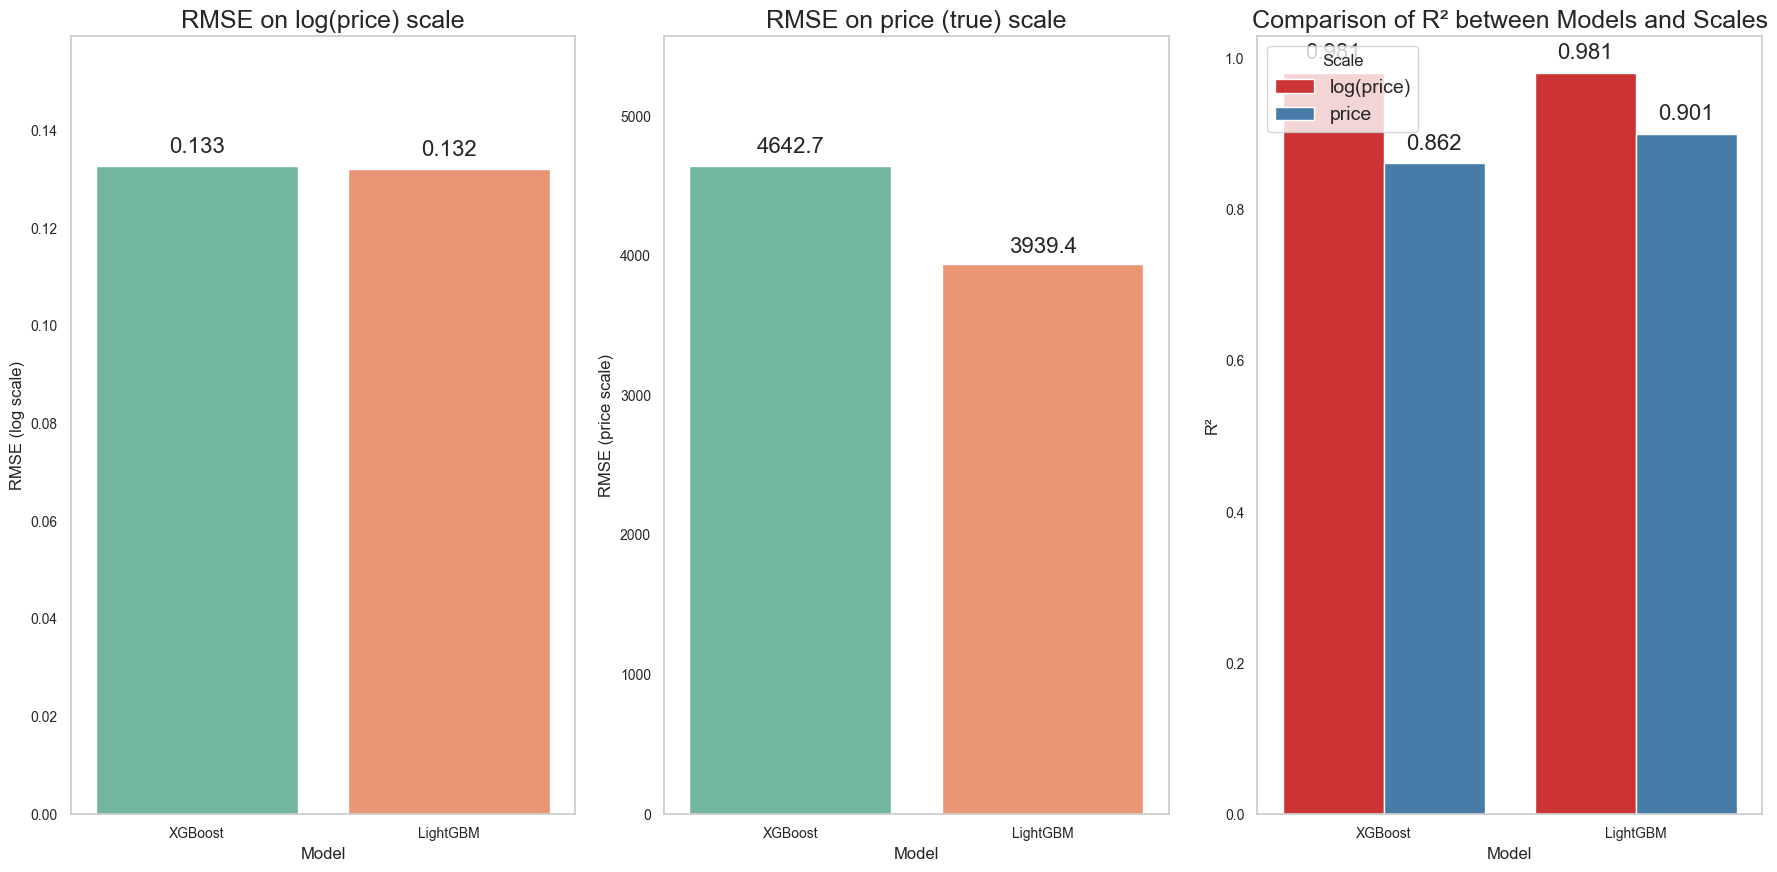

In [151]:


plt.figure(figsize=(18, 9))

# RMSE trên log(price)
plt.subplot(1, 3, 1)
ax1 = sns.barplot(data=metrics_df[metrics_df['Scale']=='log(price)'], x='Model', y='RMSE', palette='Set2')
plt.title('RMSE on log(price) scale')
plt.ylabel('RMSE (log scale)')
plt.ylim(0, metrics_df[metrics_df['Scale']=='log(price)']['RMSE'].max()*1.2)
plt.grid(axis='y')

# Hiển thị giá trị trên từng cột
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2., height * 1.02,
             f'{height:.3f}', ha='center')

# RMSE trên price (true scale)
plt.subplot(1, 3, 2)
ax2 = sns.barplot(data=metrics_df[metrics_df['Scale']=='price'], x='Model', y='RMSE', palette='Set2')
plt.title('RMSE on price (true) scale')
plt.ylabel('RMSE (price scale)')
plt.ylim(0, metrics_df[metrics_df['Scale']=='price']['RMSE'].max()*1.2)
plt.grid(axis='y')

# Hiển thị giá trị trên từng cột
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2., height * 1.02,
             f'{height:.1f}', ha='center')

# R² với palette màu khác hẳn (ví dụ Set1)
plt.subplot(1, 3, 3)
ax3 = sns.barplot(data=metrics_df, x='Model', y='R2', hue='Scale', palette='Set1')
plt.title('Comparison of R² between Models and Scales')
plt.ylabel('R²')
plt.grid(axis='y')

# Hiển thị giá trị trên từng cột cho R²
for p in ax3.patches:
    height = p.get_height()
    if height > 0:  # để tránh in những cột 0 hoặc âm không cần thiết
        ax3.text(p.get_x() + p.get_width()/2., height * 1.02,
                 f'{height:.3f}', ha='center')

plt.tight_layout()
plt.show()




#### 📊 Kết Luận Đánh Giá Mô Hình

1. **Hiệu suất chung:**
   - Cả hai mô hình **XGBoost** và **LightGBM** đều đạt được kết quả huấn luyện tốt.

2. **Đánh giá trên log(price):**
   - Sai số tuyệt đối trung bình (RMSE) và hệ số xác định (R²) của hai mô hình gần như tương đương:
     - RMSE ≈ 0.13
     - R² ≈ 0.98

3. **Đánh giá trên giá trị gốc (price):**
   - **LightGBM** có phần nhỉnh hơn so với **XGBoost** về độ chính xác:
     - RMSE: 3,939 (LightGBM) < 4,642 (XGBoost)
     - R²: 0.901 (LightGBM) > 0.862 (XGBoost)
#### 🎯 Quyết Định Lựa Chọn Mô Hình

Dựa trên kết quả đánh giá:

- Mặc dù cả hai mô hình XGBoost và LightGBM đều cho hiệu suất tốt trên cả hai thang đo log(price) và price,
- Nhưng **LightGBM** thể hiện ưu thế hơn về:
  - Sai số RMSE thấp hơn trên giá trị gốc (price),
  - Hệ số xác định R² cao hơn, phản ánh khả năng dự báo chính xác hơn.
  - **LightGBM** tối ưu bộ nhớ và tốc độ huấn luyện hơn.

**Vì vậy, mô hình LightGBM được lựa chọn làm giải pháp chính cho bài toán hồi quy này.**



## PHÂN CỤM

In [ ]:
X =df.drop(['price','carat','y','z',], axis=1)  

In [153]:
X.head()

,color,clarity,cut,table,depth,x
0,G,SI2,Excellent,58.0,62.2,5.20
1,F,SI1,Excellent,57.0,62.1,5.13
2,E,SI1,Excellent,60.0,60.8,5.09
3,E,SI1,Excellent,61.0,60.7,5.13
4,H,VS2,Excellent,57.0,63.3,5.03


#### DATA ENCODING

In [154]:
X['cut'] = encoder_cut.transform(X[['cut']])
X['color'] = encoder_color.transform(X[['color']])
X['clarity'] = encoder_clarity.transform(X[['clarity']])


In [155]:
X.head()

,color,clarity,cut,table,depth,x
0,6.0,0.0,4.0,58.0,62.2,5.20
1,7.0,1.0,4.0,57.0,62.1,5.13
2,8.0,1.0,4.0,60.0,60.8,5.09
3,8.0,1.0,4.0,61.0,60.7,5.13
4,5.0,2.0,4.0,57.0,63.3,5.03


#### NORMALIZATION - MIN_MAXSCALER

In [156]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [157]:
print(X_scaled)


[[0.66666667 0.         1.         0.45454545 0.60759494 0.03459821]
 [0.77777778 0.16666667 1.         0.36363636 0.59493671 0.02678571]
 [0.88888889 0.16666667 1.         0.63636364 0.43037975 0.02232143]
 ...
 [0.44444444 1.         1.         0.36363636 0.65822785 0.16741071]
 [0.88888889 0.33333333 0.         0.27272727 1.         0.3203125 ]
 [0.77777778 0.33333333 0.         0.36363636 0.96202532 0.140625  ]]


#### KMEANS

In [158]:
best_k = 0
best_score = -1
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_k = k
        best_score = score

# Huấn luyện KMeans với k tối ưu
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
print(f"Best k for KMeans: {best_k} with silhouette score: {best_score:.4f}")


Best k for KMeans: 2 with silhouette score: 0.5125


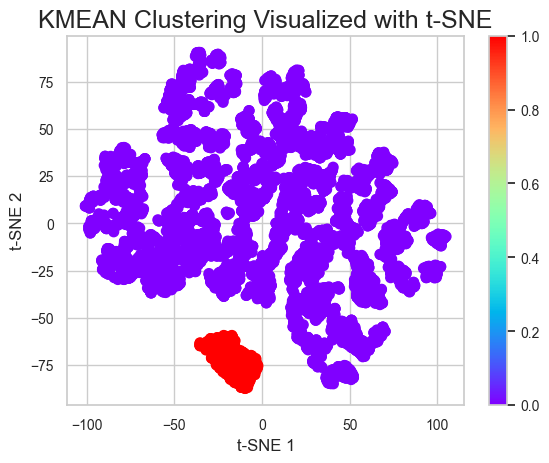

In [159]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_kmeans, cmap='rainbow', s=50)
plt.title("KMEAN Clustering Visualized with t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

In [160]:
X_kmeans = df.copy()
X_kmeans['cluster'] = labels_kmeans
numerical_cols_kmeans = [ 'depth', 'table', 'x' , 'price']
categorical_cols_kmeans = ['cut' , 'color', 'clarity']



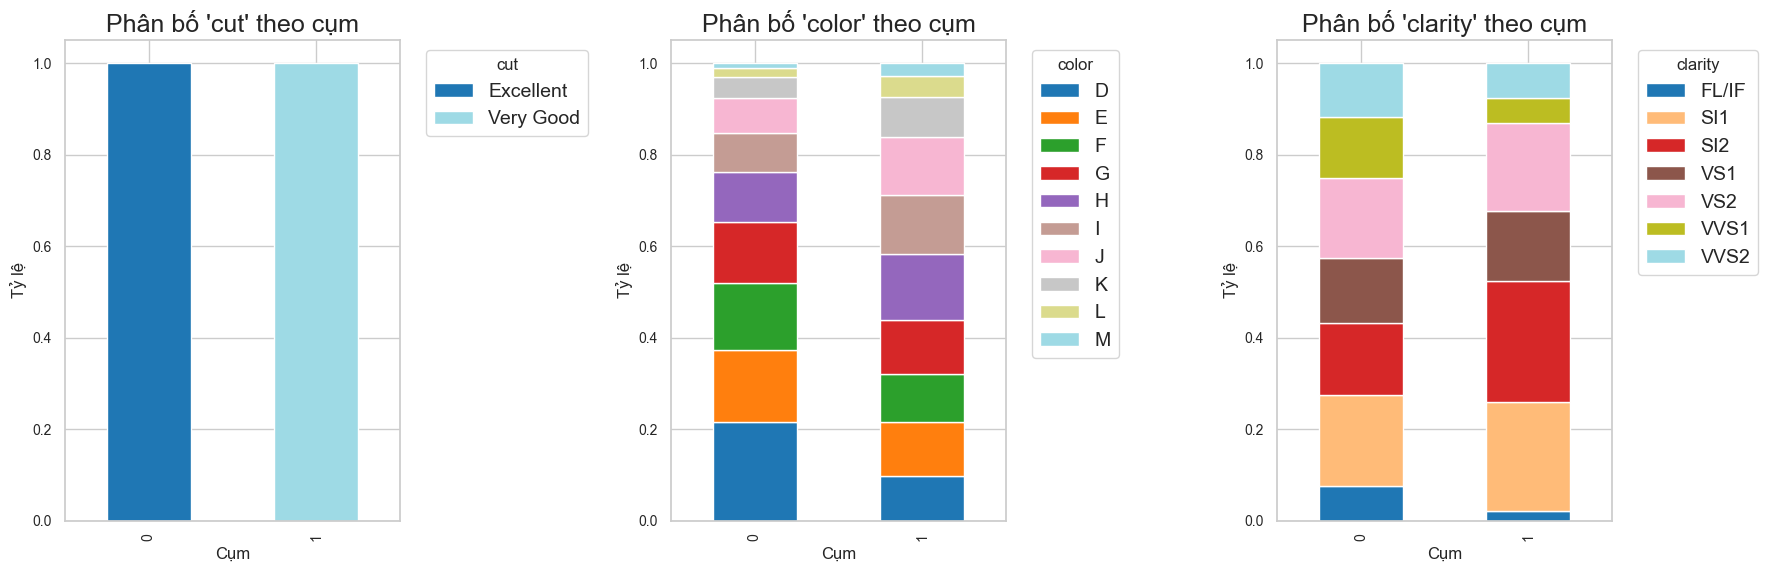

In [161]:
num_cats = len(categorical_cols_kmeans)

# Tạo figure và các subplot
fig, axes = plt.subplots(nrows=1, ncols=num_cats, figsize=(6 * num_cats, 6))  # Tăng chiều ngang theo số biến

# Nếu chỉ có 1 biến thì axes không phải list, cần chuyển
if num_cats == 1:
    axes = [axes]

# Vẽ từng biểu đồ stacked bar lên từng subplot
for i, col in enumerate(categorical_cols_kmeans):
    dist = X_kmeans.groupby('cluster')[col].value_counts(normalize=True).unstack(fill_value=0)
    dist.plot(kind='bar', stacked=True, ax=axes[i], colormap='tab20')
    axes[i].set_title(f"Phân bố '{col}' theo cụm")
    axes[i].set_xlabel("Cụm")
    axes[i].set_ylabel("Tỷ lệ")
    axes[i].legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

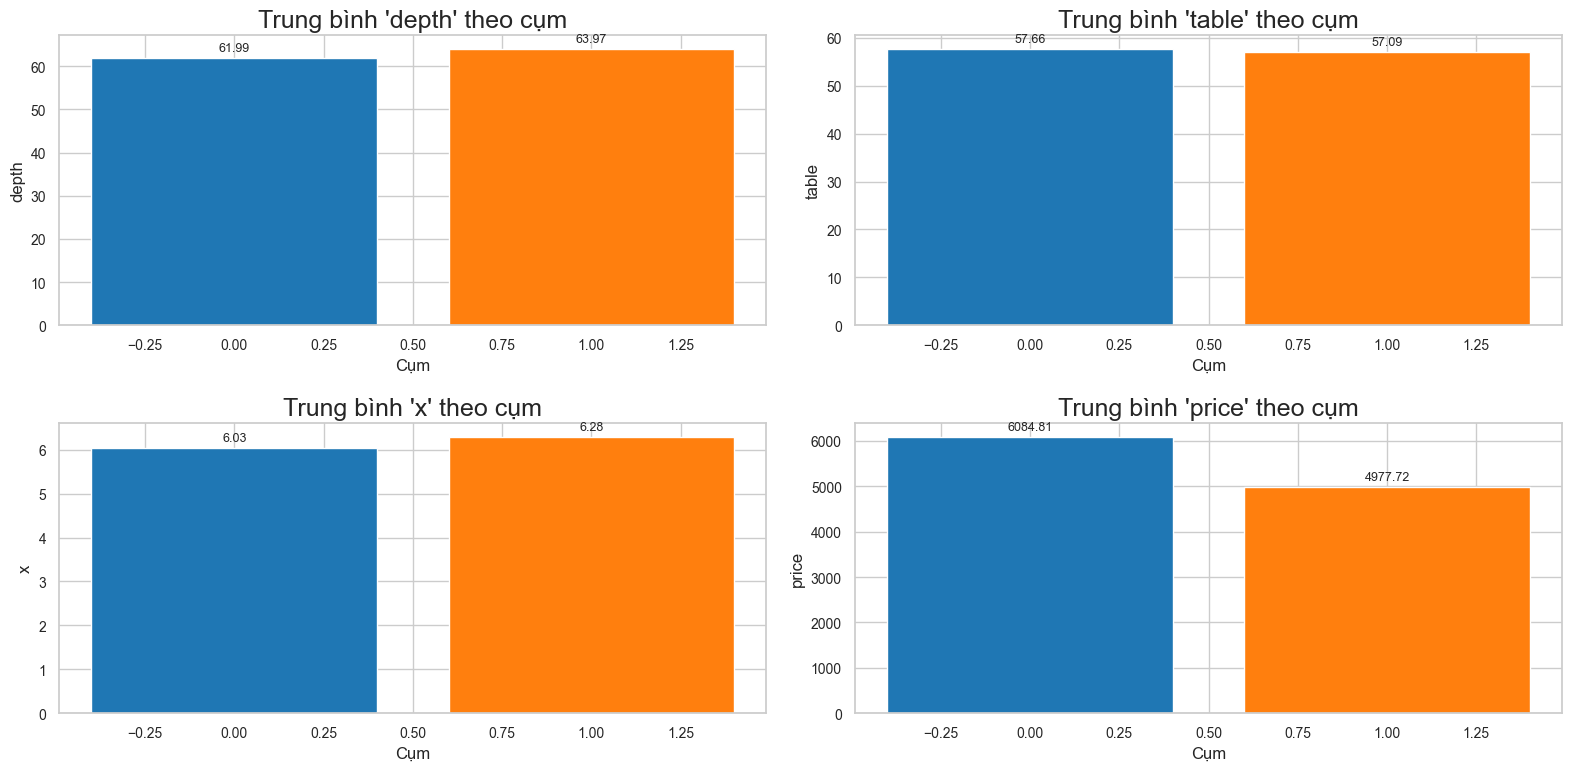

In [162]:
means = X_kmeans.groupby('cluster')[numerical_cols_kmeans].mean()
num_vars = len(numerical_cols_kmeans)

# Tạo figure và axes
fig, axes = plt.subplots(nrows=2, ncols=(num_vars + 1) // 2, figsize=(16, 8))
axes = axes.flatten()

# Màu xen kẽ
colors = ['#1f77b4', '#ff7f0e']  # Bạn có thể mở rộng nếu có nhiều cụm

for i, col in enumerate(numerical_cols_kmeans):
    ax = axes[i]
    bars = ax.bar(means.index, means[col], color=[colors[j % len(colors)] for j in range(len(means.index))])
    
    ax.set_title(f"Trung bình '{col}' theo cụm")
    ax.set_xlabel("Cụm")
    ax.set_ylabel(col)
    
    # Thêm nhãn giá trị lên cột
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # khoảng cách trên cột
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Ẩn subplot dư nếu có
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### DBSCAN

In [163]:
best_score = -1
best_eps = 0
for eps in np.arange(0.1, 0.8, 0.05):
    dbscan = DBSCAN(eps=eps, min_samples=4)
    labels = dbscan.fit_predict(X_scaled)
    
    # bỏ qua nếu toàn bộ điểm bị gán là noise
    if len(set(labels)) > 1 and -1 not in labels:
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_eps = eps
        print(f"eps={eps:.2f}, Silhouette={score:.4f}")

print(f"\nBest eps = {best_eps:.2f} with Silhouette = {best_score:.4f}")



eps=0.45, Silhouette=0.5125
eps=0.50, Silhouette=0.5125
eps=0.55, Silhouette=0.5125
eps=0.60, Silhouette=0.5125
eps=0.65, Silhouette=0.5125
eps=0.70, Silhouette=0.5125
eps=0.75, Silhouette=0.5125

Best eps = 0.45 with Silhouette = 0.5125


In [164]:
dbscan = DBSCAN(eps=0.50, min_samples=4)
labels_dbscan = dbscan.fit_predict(X_scaled)

# DBSCAN có thể tạo ra nhãn -1 (noise), nên cần lọc
n_clusters = len(set(labels_dbscan))
print(set(labels_dbscan))

if n_clusters > 1:
    score_dbscan = silhouette_score(X_scaled, labels_dbscan)
else:
    score_dbscan = -1
print(f"DBSCAN found {n_clusters} clusters with silhouette score: {score_dbscan:.4f}")

{np.int64(0), np.int64(1)}
DBSCAN found 2 clusters with silhouette score: 0.5125


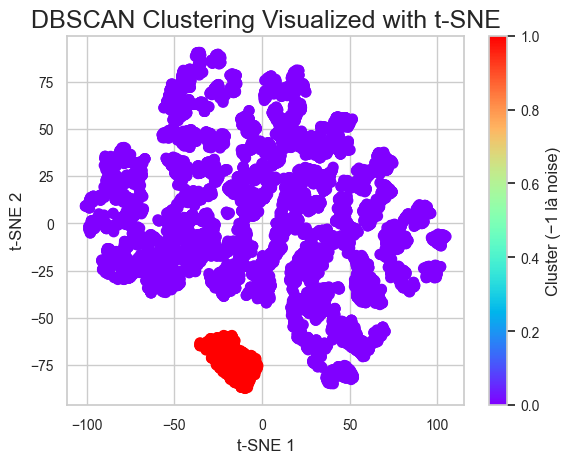

In [165]:


plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_dbscan, cmap='rainbow', s=50)
plt.title("DBSCAN Clustering Visualized with t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="Cluster (−1 là noise)")
plt.show()

### ĐÁNH GIÁ MÔ HÌNH
##### 📌 1. Silhouette Score

**Ý nghĩa**:  
Silhouette Score đánh giá *mức độ tách biệt và gắn kết* của các cụm. Mỗi điểm dữ liệu có một chỉ số silhouette thể hiện mức độ phù hợp với cụm của nó so với các cụm khác.

**Công thức**:

$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$

Trong đó:
- $ a(i) $: khoảng cách trung bình từ điểm $ i $ đến các điểm khác trong **cùng cụm**.  
- $ b(i) $: khoảng cách trung bình từ điểm $ i $ đến các điểm trong **cụm gần nhất khác**.

**Giá trị nằm trong [-1, 1]**:
- $ \approx 1 $: phân cụm tốt (điểm gần cụm của nó và xa cụm khác).
- $ \approx 0 $: điểm ở ranh giới giữa các cụm.
- $ < 0 $: điểm có thể bị gán sai cụm.

👉 **Càng cao càng tốt**.

---

##### 📌 2. Davies-Bouldin Index (DBI)

**Ý nghĩa**:  
Chỉ số **Davies-Bouldin (DBI)** đo mức độ **chồng lấn giữa các cụm** trong phân cụm.

- **DBI thấp** → các cụm **tách biệt rõ ràng**, dữ liệu phân cụm **tốt**.
- **DBI cao** → các cụm **phân tán hoặc gần nhau**, dễ **chồng lấn**, phân cụm **kém hiệu quả**.

**Công thức**:

$
DBI = \frac{1}{k} \sum_{i=1}^k \max_{j \neq i} \left( \frac{s_i + s_j}{d_{ij}} \right)
$

Trong đó:
- $ s_i $: độ phân tán trong cụm $ i $ (ví dụ: khoảng cách trung bình giữa các điểm với centroid).
- $ d_{ij} $: khoảng cách giữa tâm của cụm $ i $ và cụm $ j $.
- $ k $: số cụm.

**Giá trị DBI ≥ 0**:
- **Càng thấp càng tốt**: các cụm càng khác nhau và cô đọng hơn.

---

##### 🧠 So sánh nhanh

| Metric               | Thang điểm   | Mục tiêu     | Diễn giải                             |
|----------------------|---------------|--------------|----------------------------------------|
| Silhouette Score     | -1 → 1        | Maximize     | Cao: cụm rõ ràng, tách biệt            |
| Davies-Bouldin Index | ≥ 0           | Minimize     | Thấp: cụm nhỏ gọn và phân tách tốt     |


In [166]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Đánh giá KMeans
sil_k = silhouette_score(X_scaled, labels_kmeans)
db_k = davies_bouldin_score(X_scaled, labels_kmeans)


# Đánh giá DBSCAN
if n_clusters > 1:
    sil_d = silhouette_score(X_scaled, labels_dbscan)
    db_d = davies_bouldin_score(X_scaled, labels_dbscan)
    
else:
    sil_d = db_d = ch_d = -1  # Không đủ cụm để tính

In [167]:
print(f"KMeans: Silhouette={sil_k:.4f}, Davies-Bouldin={db_k:.4f}")
print(f"DBSCAN: Silhouette={sil_d:.4f}, Davies-Bouldin={db_d:.4f}")


KMeans: Silhouette=0.5125, Davies-Bouldin=0.8166
DBSCAN: Silhouette=0.5125, Davies-Bouldin=0.8166


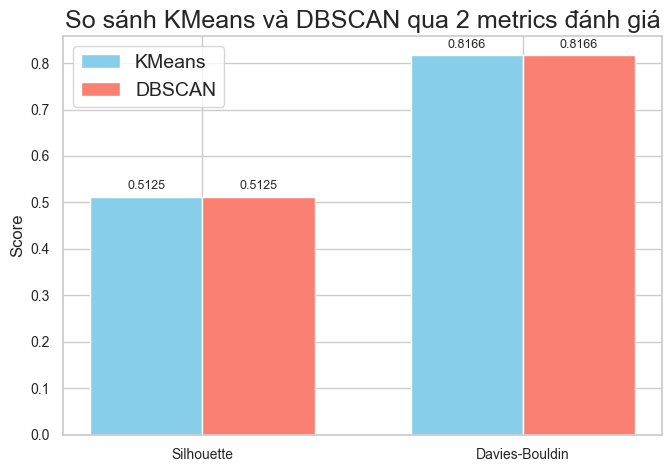

In [168]:

# Tên metrics
metrics = ['Silhouette', 'Davies-Bouldin']
kmeans_scores = [sil_k, db_k]
dbscan_scores = [sil_d, db_d]

x = range(len(metrics))
bar_width = 0.35

plt.figure(figsize=(7, 5))

# Vẽ cột KMeans
bars1 = plt.bar(x, kmeans_scores, width=bar_width, label='KMeans', color='skyblue')
# Vẽ cột DBSCAN
bars2 = plt.bar([i + bar_width for i in x], dbscan_scores, width=bar_width, label='DBSCAN', color='salmon')

# Thêm giá trị trên đầu mỗi cột
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.4f}', 
             ha='center', va='bottom', fontsize=9)

# Thiết lập trục và tiêu đề
plt.xticks([i + bar_width / 2 for i in x], metrics)
plt.ylabel('Score')
plt.title('So sánh KMeans và DBSCAN qua 2 metrics đánh giá')
plt.legend()
plt.tight_layout()
plt.show()


**Đánh giá và Giải thích Kết quả Phân cụm Kim cương**

1. Nhận xét và Đánh giá

Metrics Phân cụm (Silhouette & Davies-Bouldin):
* **K-Means:** Silhouette = 0.5125, Davies-Bouldin = 0.8166
* **DBSCAN:** Silhouette = 0.5125, Davies-Bouldin = 0.8166
* **Đánh giá:** Cả hai thuật toán K-Means và DBSCAN cho ra kết quả metrics **hoàn toàn giống nhau**, đều ở mức tốt (Silhouette > 0.5 và Davies-Bouldin thấp).

Trực quan hóa t-SNE:
* **K-Means & DBSCAN:** Hai biểu đồ t-SNE **giống hệt nhau**, cùng hiển thị một cụm nhỏ riêng biệt và một cụm lớn hơn. Không có dấu hiệu nhiễu rõ ràng từ DBSCAN.
* **Đánh giá:** Trực quan hóa xác nhận các nhãn cụm được tạo ra bởi hai thuật toán là như nhau, cho thấy một cấu trúc cụm rõ ràng và ổn định.

2. Giải thích

Sự trùng khớp tuyệt đối về cả metrics lẫn hình ảnh trực quan t-SNE giữa K-Means và DBSCAN là do **dữ liệu của bạn có một cấu trúc cụm nội tại cực kỳ mạnh mẽ và rõ ràng**, bao gồm hai cụm được phân tách rất tốt.

Mặc dù K-Means dựa trên khoảng cách đến tâm cụm và DBSCAN dựa trên mật độ, trong trường hợp này, cả hai đã **hội tụ về cùng một giải pháp phân cụm tối ưu**. Điều này cũng được củng cố bởi việc DBSCAN không phát hiện ra điểm nhiễu (`-1`), ngụ ý rằng tất cả các điểm đều thuộc về một trong hai cụm được định nghĩa rõ ràng.

Biến **cut** chỉ có 2 loại là **Excellent** và **Good** gần như là nguyên nhân chính dẫn đến sự rõ ràng, tách biệt giữa 2 cụm và sự nhất quát của 2 mô hình K-Means và DBSCAN
